In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [3]:
import pickle
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util
from pipeline.model import bandit_model

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


In [4]:
# select units
def select_unit_qc_region_mouse_session(all_unit_qc, region_annotation="Prelimbic%", mouse="HH09", session=47):
    unit_qc_region = (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "{}"'.format(region_annotation)
    return unit_qc_region & (lab.WaterRestriction & 'water_restriction_number = "{}"'.format(mouse)) & 'session = {}'.format(session)
    

# fetch keys
def gen_keys2units(unit_qc_region_mouse_session):
    # get all keys
    keys2units = unit_qc_region_mouse_session.fetch('KEY')
    print('num of units: {}'.format(len(keys2units)))

    return keys2units

In [5]:
# fetch data from brain region
region_ann_lut = {
    # premotor
    'ALM': "Secondary motor area%",
    # isocortex, PFC
    'PL': "Prelimbic%",
    'ACA': "Anterior cingulate area%",
    'ILA': "Infralimbic%",
    'ORB': '%orbital%',
    'FRP': '%frontal%',
    'RSP': "Retrosplenial area%",
    # thalamus
    'VM': 'Ventral medial%',
    'MD': 'Mediodorsal%',
    # striatum
    'LSN': "Lateral septal nucleus%",
    'CP': "Caudoputamen%",
    'NA': "Nucleus accumbens%",
    'striatum': "striatum%",
    # Pallidum
    'PALv': "Substantia innominata%",
    # Olfactory
    'OLF': "%olfactory%",
}

In [6]:
# fetch unit data
# after unit qc
foraging_session = experiment.Session & 'username = "hh"'
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & foraging_session & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:]

,count
annotation,
"Lateral septal nucleus, rostral (rostroventral) part",801
Caudoputamen,473
"Secondary motor area, layer 6a",401
"Secondary motor area, layer 5",294
"Prelimbic area, layer 5",286
...,...
Ethmoid nucleus of the thalamus,1
"Retrosplenial area, ventral part, layer 6a",1
Triangular nucleus of septum,1


In [10]:
# fetch and organize data

period = 'iti_all'
# periods: experiment.PeriodForaging

model_id = 10

# use only latter sessions
latter_session = 30

regions = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
mouses = {
    'ALM': 'HH13', #sess=4
    'PL': 'HH08', #sess=4
    'ACA': 'HH13', #sess=5
    'ORB': 'HH09', #sess=4
    'LSN': 'HH13', #sess=6
    'striatum': 'HH08', #sess=5
    'MD': 'HH09' #sess=4
}

neuron_columns = ['session', 'unit', 'firing_rates']
neurons = {region: pd.DataFrame(columns=neuron_columns) for region in regions}

q_latent_columns = ['session', 'Q_left', 'Q_right']
q_latents = {region: None for region in regions}


for region in regions:
    mouse = mouses[region]
    subject_id = (lab.WaterRestriction & f'water_restriction_number="{mouse}"').fetch('subject_id')[0]
    print(f'region: {region}')
    
    # get fitted latent variables
    q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & 
                         {'model_id': model_id, 'subject_id': subject_id})
    df_Q = pd.DataFrame(q_latent_variable.fetch())
    df_Q_left = df_Q[df_Q['water_port']=='left'][['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
    df_Q_right = df_Q[df_Q['water_port']=='right'][['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
    df_Qs = df_Q_left.merge(df_Q_right)
    q_latents[region] = df_Qs

    sessions_all = np.unique(df_Qs['session'].values)
    sessions = sessions_all[sessions_all > latter_session]


    for session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==session]
        ## check if Q_left or Q_right are missing
        if np.isnan(df_Qs_session['Q_left'].values).any() or np.isnan(df_Qs_session['Q_right'].values).any():
            Q_left_nan = np.where(np.isnan(df_Qs_session['Q_left'].values))[0]
            Q_right_nan = np.where(np.isnan(df_Qs_session['Q_right'].values))[0]
            print(f' nan present in Qs: region {region}, sess {session}, left {Q_left_nan}, right {Q_right_nan}')
            print(' dropping nan')
            df_Qs_session.dropna(subset=['Q_left', 'Q_right'], inplace=True)

        unit_qc_region_mouse_session = select_unit_qc_region_mouse_session(
                                            all_unit_qc, 
                                            region_annotation=region_ann_lut[region], 
                                            mouse=mouse, 
                                            session=session)
        if len(unit_qc_region_mouse_session) > 0:
            print(f'total number of units in {region} in sess {session}: {len(unit_qc_region_mouse_session)}')
            # fetch keys
            keys2units = gen_keys2units(unit_qc_region_mouse_session)

            trials_q = df_Qs_session['trial'].values
            # get unit activity
            for unit_key in keys2units:
                unit = unit_key['unit']
                
                period_activity = psth_foraging.compute_unit_period_activity(unit_key, period)
                trials_unit = period_activity['trial']

                # correct mismatch trials from q and unit
                trials_q_not_in_unit = trials_q[~np.isin(trials_q, trials_unit)]
                if np.any(trials_q_not_in_unit):
                    print(f' mismatch: {region} {session}, trials_q_not_in_unit: {trials_q_not_in_unit}')
                    for t in trials_q_not_in_unit:
                        df_Qs_session.drop(df_Qs_session[df_Qs_session['trial']==t].index, inplace=True)
                trials_q = trials_q[np.isin(trials_q, trials_unit)]

                firing_rate = period_activity['firing_rates']
                # get only the valid trials
                valid_firing_rate = firing_rate[np.isin(trials_unit, trials_q)]

                neurons[region].loc[len(neurons[region].index)] = [session, unit, valid_firing_rate]


/home/map/.local/lib/python3.6/site-packages/datajoint/connection.py:219: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


region: ALM
total number of units in ALM in sess 33: 37
num of units: 37
total number of units in ALM in sess 34: 107
num of units: 107
total number of units in ALM in sess 36: 197
num of units: 197
total number of units in ALM in sess 37: 54
num of units: 54
region: PL
total number of units in PL in sess 49: 76
num of units: 76
total number of units in PL in sess 50: 48
num of units: 48
total number of units in PL in sess 51: 4
num of units: 4
total number of units in PL in sess 52: 93
num of units: 93
region: ACA
total number of units in ACA in sess 33: 3
num of units: 3
total number of units in ACA in sess 34: 64
num of units: 64
total number of units in ACA in sess 36: 136
num of units: 136
total number of units in ACA in sess 37: 57
num of units: 57
total number of units in ACA in sess 43: 24
num of units: 24
region: ORB
total number of units in ORB in sess 46: 154
num of units: 154
total number of units in ORB in sess 47: 80
num of units: 80
total number of units in ORB in sess 4

In [ ]:
# save the data df if not existed
with open('./neurons_data_match_iti_all.pickle', 'wb') as handle:
    pickle.dump(neurons, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./q_latents_match.pickle', 'wb') as handle:
    pickle.dump(q_latents, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# load data
with open('./neurons_data_match_iti_all.pickle', 'rb') as handle:
    neurons = pickle.load(handle)

with open('./q_latents_match.pickle', 'rb') as handle:
    q_latents = pickle.load(handle)

In [7]:
# check trial length mismatch issue
regions = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
for region in regions:
    neurons_region = neurons[region]
    df_Qs = q_latents[region]
    for sess in np.unique(neurons_region['session'].values):
        neurons_region_session = neurons_region[neurons_region['session']==sess]
        fr_len = neurons_region_session.iloc[0]['firing_rates'].shape[0]
        q_len = len(df_Qs[df_Qs['session']==sess])
        if fr_len != q_len:
            print(f'{region} {sess}: fr - {fr_len}, q - {q_len}')

### Standard analysis

In [8]:
# std fit, single neuron encoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']

std_encode_columns = ['src_session', 'unit', 'fit_session', 'tvalues_Q_left', 'tvalues_Q_right']
df_std_encode_dict = {region: pd.DataFrame(columns=std_encode_columns) for region in regions}

# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    
    df_std_fit = df_std_encode_dict[region]

    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        X = sm.add_constant(X)
        print(f' session {session}: {X.shape}')

        for unit in np.unique(neurons_region_session['unit'].values):
            fr = neurons_region_session[(neurons_region_session['unit']==unit)].iloc[0]['firing_rates']
            
            model = sm.OLS(fr, X)
            results = model.fit()
            df_std_fit.loc[len(df_std_fit.index)] = [session, unit, session, results.tvalues['Q_left'], results.tvalues['Q_right']]

region ALM
 session 33: (586, 3)
 session 34: (379, 3)
 session 36: (450, 3)
 session 37: (321, 3)
region PL
 session 49: (748, 3)
 session 50: (634, 3)
 session 51: (594, 3)
 session 52: (543, 3)
region ACA
 session 33: (586, 3)
 session 34: (379, 3)
 session 36: (450, 3)
 session 37: (321, 3)
 session 43: (791, 3)
region ORB
 session 46: (277, 3)
 session 47: (421, 3)
 session 48: (178, 3)
 session 50: (272, 3)
region LSN
 session 33: (586, 3)
 session 34: (379, 3)
 session 36: (450, 3)
 session 37: (321, 3)
 session 42: (1142, 3)
 session 43: (791, 3)
region striatum
 session 49: (748, 3)
 session 50: (634, 3)
 session 51: (594, 3)
 session 52: (543, 3)
region MD
 session 57: (359, 3)
 session 58: (262, 3)
 session 59: (342, 3)
 session 60: (736, 3)


ALM total dots: 382
 classified Q_left: 104
 classified Q_right: 77
 classified sigma_Q: 41
 classified delta_Q: 21
PL total dots: 218
 classified Q_left: 45
 classified Q_right: 42
 classified sigma_Q: 60
 classified delta_Q: 3
ACA total dots: 284
 classified Q_left: 60
 classified Q_right: 50
 classified sigma_Q: 27
 classified delta_Q: 12
ORB total dots: 347
 classified Q_left: 69
 classified Q_right: 65
 classified sigma_Q: 22
 classified delta_Q: 5
LSN total dots: 704
 classified Q_left: 117
 classified Q_right: 81
 classified sigma_Q: 51
 classified delta_Q: 4
striatum total dots: 67
 classified Q_left: 12
 classified Q_right: 10
 classified sigma_Q: 22
 classified delta_Q: 0
MD total dots: 75
 classified Q_left: 19
 classified Q_right: 9
 classified sigma_Q: 21
 classified delta_Q: 2


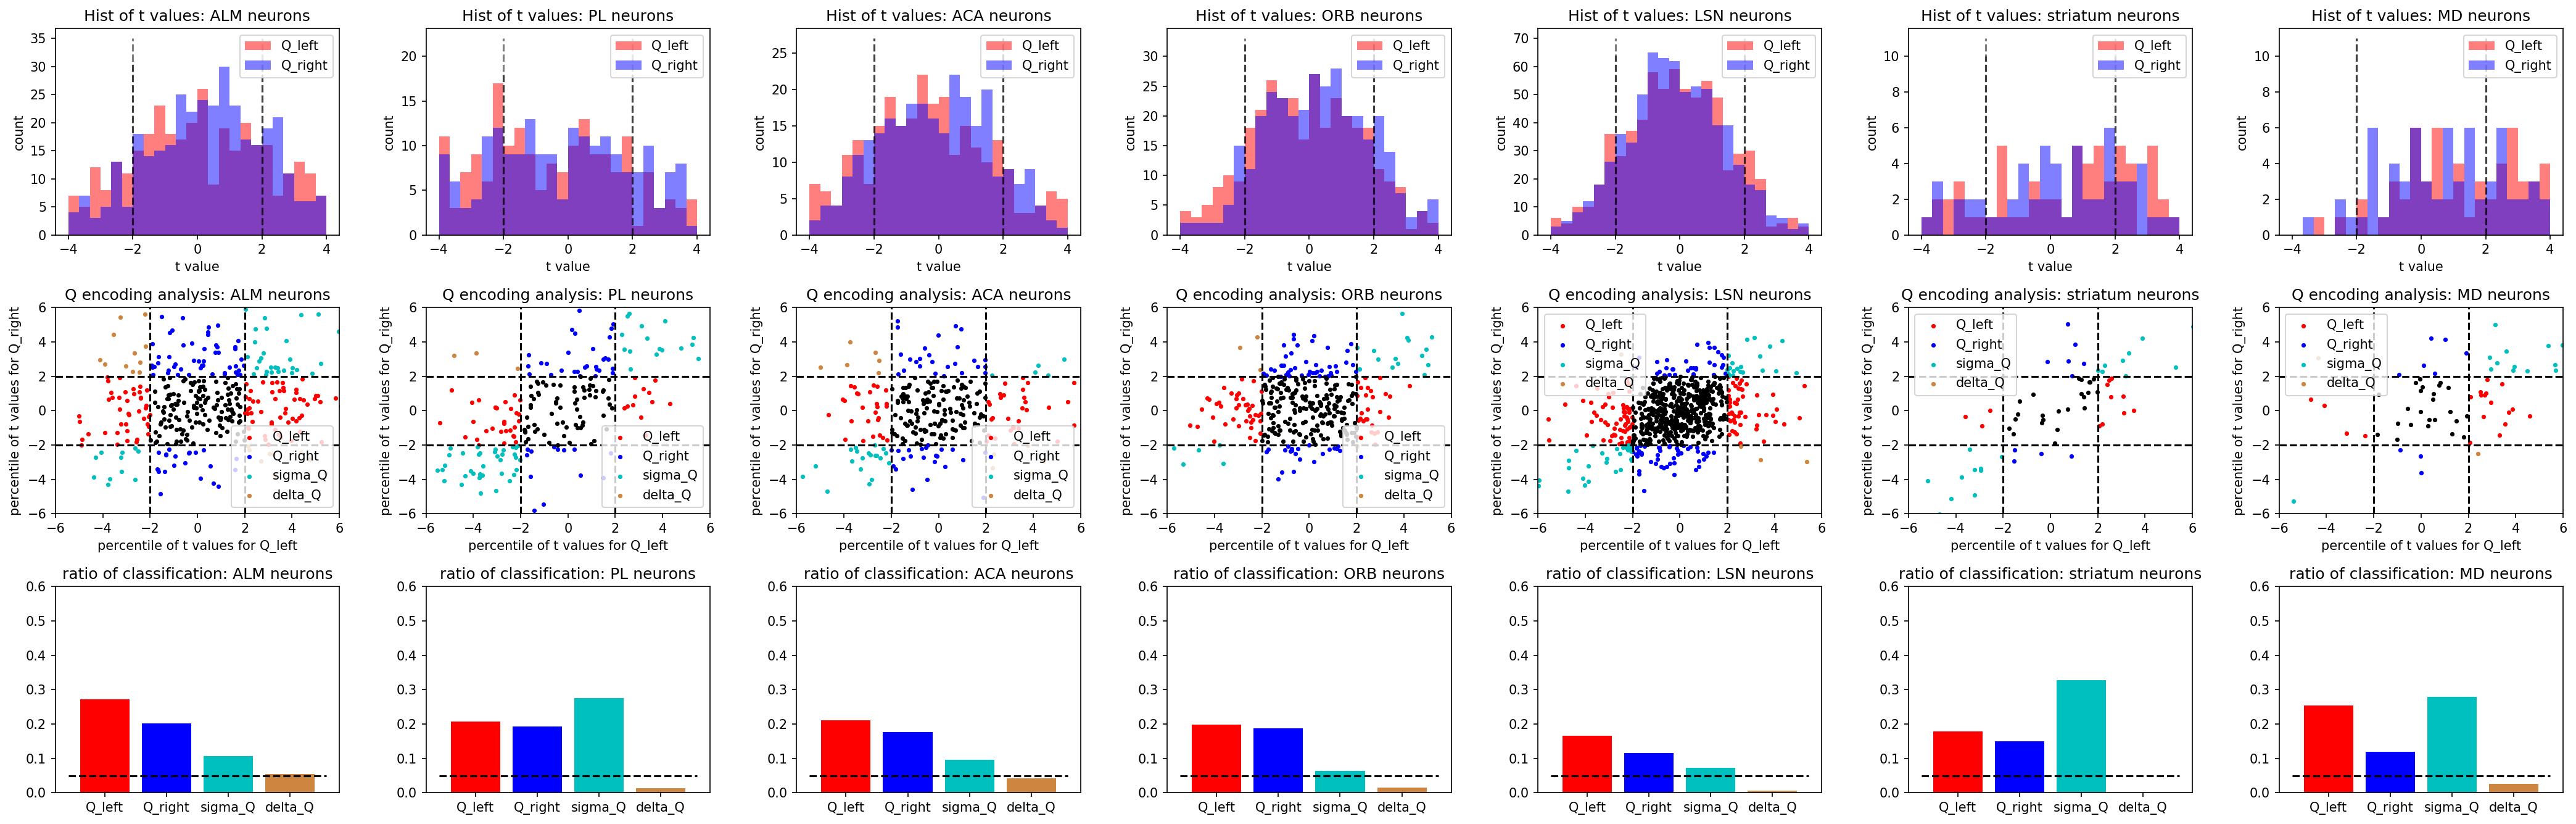

In [9]:
# plot std fit, single neuron encoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
percentiles_2_compute = [2.5, 97.5]

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b'}
hist_lim = (-4, 4)
# scatter plot
tvalue_lim = (-6, 6)
tvalue_sig_thresh = (-2, 2)
dot_size = 6
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(3, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*3), dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_std_encode_dict[region]
    tvalues_percentile = {'Q_left': None, 'Q_right': None}
    # histogram of regression tvalues
    row_ind = 0
    for i, q_side in enumerate(['Q_left', 'Q_right']):
        tvalues_q_side = df_fit[f'tvalues_{q_side}'].values
        tvalues_percentile_q_side = np.percentile(tvalues_q_side, percentiles_2_compute)
        tvalues_percentile[q_side] = tvalues_percentile_q_side
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(tvalues_q_side, bins=24, range=hist_lim, histtype='stepfilled', 
                                                       color=colors[q_side], label=q_side, alpha=0.5)
        axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_side)+5, 
                                     color='k', linestyle='--', alpha=0.5)
        #axs[row_ind, col_ind].vlines(tvalues_percentile_q_side, 0, hist_top, 
        #                             color=colors[q_side], linestyle='--', alpha=0.5)

    axs[row_ind, col_ind].set_title(f'Hist of t values: {region} neurons')
    axs[row_ind, col_ind].set_xlabel('t value')
    axs[row_ind, col_ind].set_ylabel('count')
    axs[row_ind, col_ind].legend()

    
    # scatter plot of neurons
    row_ind = 1
    # choose tvalue_sig_threshold
    # (-2, 2) for naive case
    tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 'Q_right': tvalue_sig_thresh} 
    # dynamic for adv analysis
    # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
    df_fit_Q_left_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                (df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                               (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                               (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_left_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_left_sig['tvalues_Q_right'].values, 
                                  color='r', s=dot_size, label='Q_left')
    df_fit_Q_right_sig = df_fit[((df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_right_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_right_sig['tvalues_Q_right'].values, 
                                  color='b', s=dot_size, label='Q_right')
    df_fit_sigma_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
    axs[row_ind, col_ind].scatter(df_fit_sigma_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_sigma_Q_sig['tvalues_Q_right'].values, 
                                  color='c', s=dot_size, label='sigma_Q')
    df_fit_delta_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
    axs[row_ind, col_ind].scatter(df_fit_delta_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_delta_Q_sig['tvalues_Q_right'].values, 
                                  color='peru', s=dot_size, label='delta_Q')
    df_fit_null = df_fit[(df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                         (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                         (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                         (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_null['tvalues_Q_left'].values, 
                                  df_fit_null['tvalues_Q_right'].values, 
                                  color='k', s=dot_size)
    sum_classified_neurons = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                             len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                             len(df_fit_null)
    if len(df_fit) != sum_classified_neurons:
        raise ValueError(f'sum of dots doesnt match: {len(df_fit)} {sum_classified_neurons}')

    axs[row_ind, col_ind].hlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].vlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'Q encoding analysis: {region} neurons')
    axs[row_ind, col_ind].set_xlim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_ylim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
    axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
    axs[row_ind, col_ind].legend()


    # bar plot for significant neurons
    row_ind = 2
    
    print(f'{region} total dots: {len(df_fit)}')
    print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
    print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
    print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
    print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
    classified_ratios = [
        len(df_fit_Q_left_sig)/ float(len(df_fit)),
        len(df_fit_Q_right_sig)/ float(len(df_fit)),
        len(df_fit_sigma_Q_sig)/ float(len(df_fit)),
        len(df_fit_delta_Q_sig)/ float(len(df_fit))]
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 0.6)

plt.tight_layout()

In [11]:
# std fit, single neuron decoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
 
std_decode_columns = ['src_session', 'unit', 'fit_session', 'target_variable', 'ftest_pvalue']
df_std_decode_dict = {region: pd.DataFrame(columns=std_decode_columns) for region in regions_to_fit}


# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    
    df_std_fit = df_std_decode_dict[region]

    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        for target_variable in target_variables:
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            #print(f' sess {session}, target {target_variable}: {X.shape}')

            for unit in np.unique(neurons_region_session['unit'].values):
                fr = neurons_region_session[(neurons_region_session['unit']==unit)].iloc[0]['firing_rates']
                fr = sm.add_constant(fr)
                
                # decoding models: fr --> X
                model = sm.OLS(X, fr)
                results = model.fit()
                df_std_fit.loc[len(df_std_fit.index)] = [session, unit, session, target_variable, results.f_pvalue]


region ALM
region PL
region ACA
region ORB
region LSN
region striatum
region MD


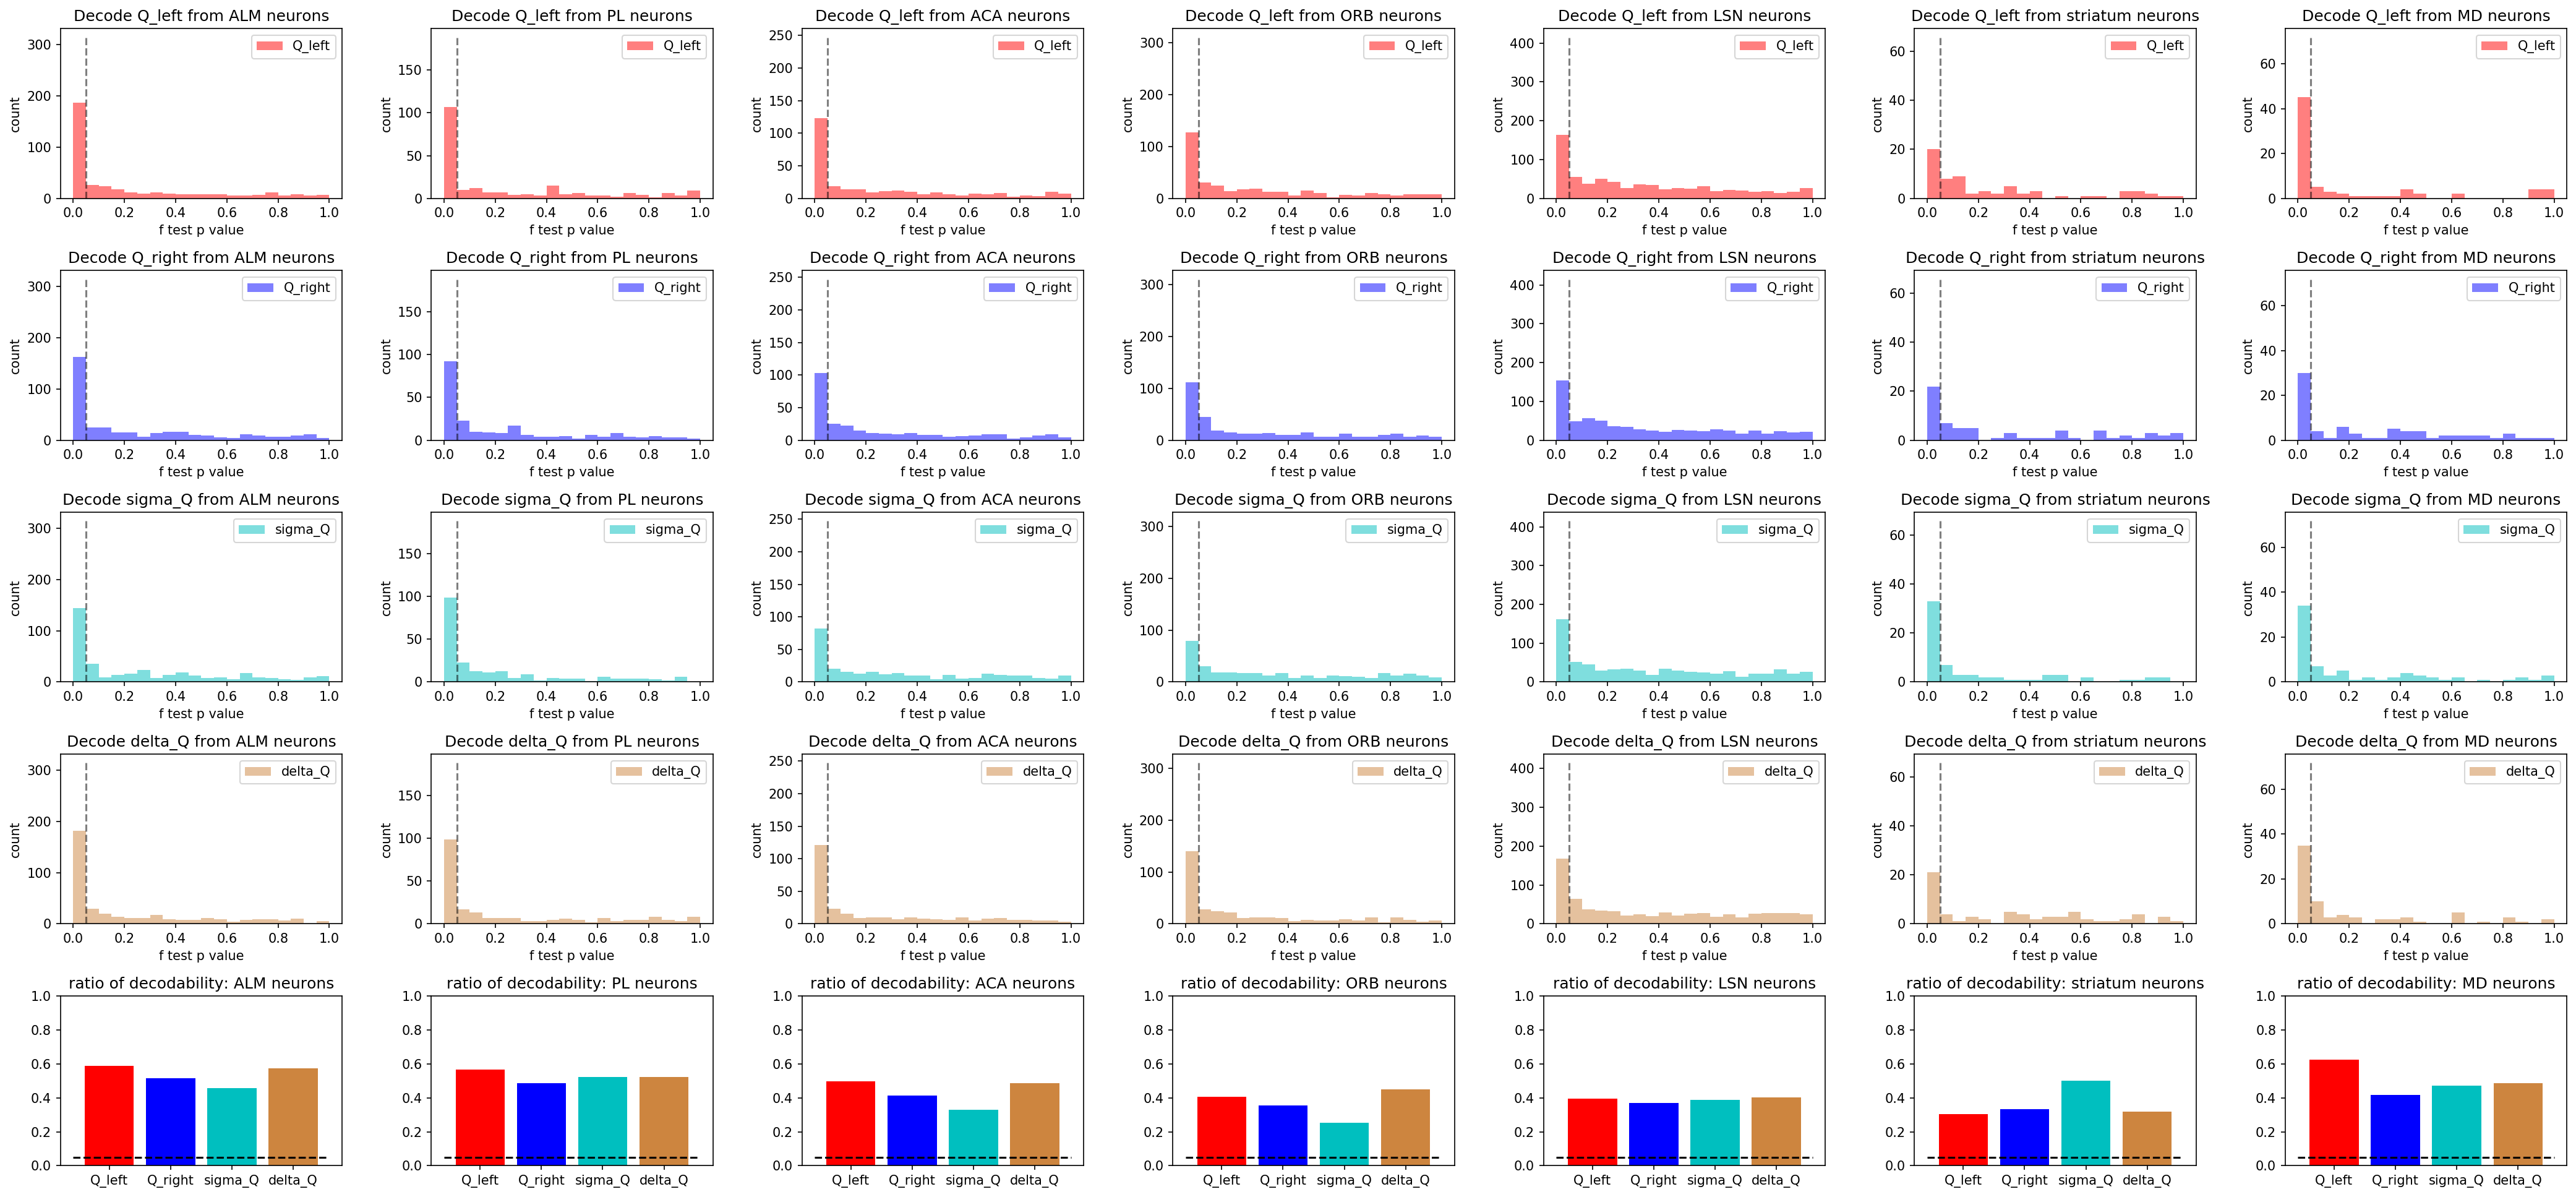

In [12]:
# plot std fit, single neuron decoding

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05

# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*len(target_variables)+1),
                        dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_std_decode_dict[region]
    n_unique_neurons = len(np.unique(df_fit['unit'].values))

    n_sig_neurons = {target_variable: None for target_variable in target_variables}
    for i, target_variable in enumerate(target_variables):
        
        # histogram of regression tvalues
        row_ind = i
        ftest_pvalues = df_fit[df_fit['target_variable']==target_variable]['ftest_pvalue'].values
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues, bins=20, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                       color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(pvalue_sig_thresh, 0, n_unique_neurons, 
                                     color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {region} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_neurons[target_variable] = np.sum(ftest_pvalues < 0.05)

    
    # bar plot for significant neurons
    row_ind = len(target_variables)
    classified_ratios = [n_sig_neurons[target_variable]/ float(n_unique_neurons) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decodability: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1)

plt.tight_layout()

In [13]:
# std fit, poppulation decoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
 
std_decode_pop_columns = ['src_session', 'fit_session', 'target_variable', 'ftest_pvalue']
df_std_decode_pop_dict = {region: pd.DataFrame(columns=std_decode_pop_columns) for region in regions}


# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)
    
    df_Qs = q_latents[region]
    df_std_fit = df_std_decode_pop_dict[region]

    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]
        
        fr = np.empty((neurons_region_session.iloc[0]['firing_rates'].shape[0], 
                       len(neurons_region_session)))
        for j in range(len(neurons_region_session)):
            fr[:, j] = neurons_region_session.iloc[j]['firing_rates']
        fr = sm.add_constant(fr)
        print(f' sess {session} fr shape {fr.shape}')

        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        print(f' sess {session} df_Qs shape {df_Qs_session.shape}')
        for target_variable in target_variables:
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            #print(f' sess {session}, target {target_variable}: {X.shape}')

            # decoding models: fr --> X
            model = sm.OLS(X, fr)
            results = model.fit()
            df_std_fit.loc[len(df_std_fit.index)] = [session, session, target_variable, results.f_pvalue]


region ALM
 sess 33 fr shape (586, 38)
 sess 33 df_Qs shape (586, 4)
 sess 34 fr shape (379, 108)
 sess 34 df_Qs shape (379, 4)
 sess 36 fr shape (450, 198)
 sess 36 df_Qs shape (450, 4)
 sess 37 fr shape (321, 55)
 sess 37 df_Qs shape (321, 4)
region PL
 sess 49 fr shape (748, 77)
 sess 49 df_Qs shape (748, 4)
 sess 50 fr shape (634, 49)
 sess 50 df_Qs shape (634, 4)
 sess 51 fr shape (594, 5)
 sess 51 df_Qs shape (594, 4)
 sess 52 fr shape (543, 94)
 sess 52 df_Qs shape (543, 4)
region ACA
 sess 33 fr shape (586, 4)
 sess 33 df_Qs shape (586, 4)
 sess 34 fr shape (379, 65)
 sess 34 df_Qs shape (379, 4)
 sess 36 fr shape (450, 137)
 sess 36 df_Qs shape (450, 4)
 sess 37 fr shape (321, 58)
 sess 37 df_Qs shape (321, 4)
 sess 43 fr shape (791, 25)
 sess 43 df_Qs shape (791, 4)
region ORB
 sess 46 fr shape (277, 155)
 sess 46 df_Qs shape (277, 4)
 sess 47 fr shape (421, 81)
 sess 47 df_Qs shape (421, 4)
 sess 48 fr shape (178, 65)
 sess 48 df_Qs shape (178, 4)
 sess 50 fr shape (272, 50)

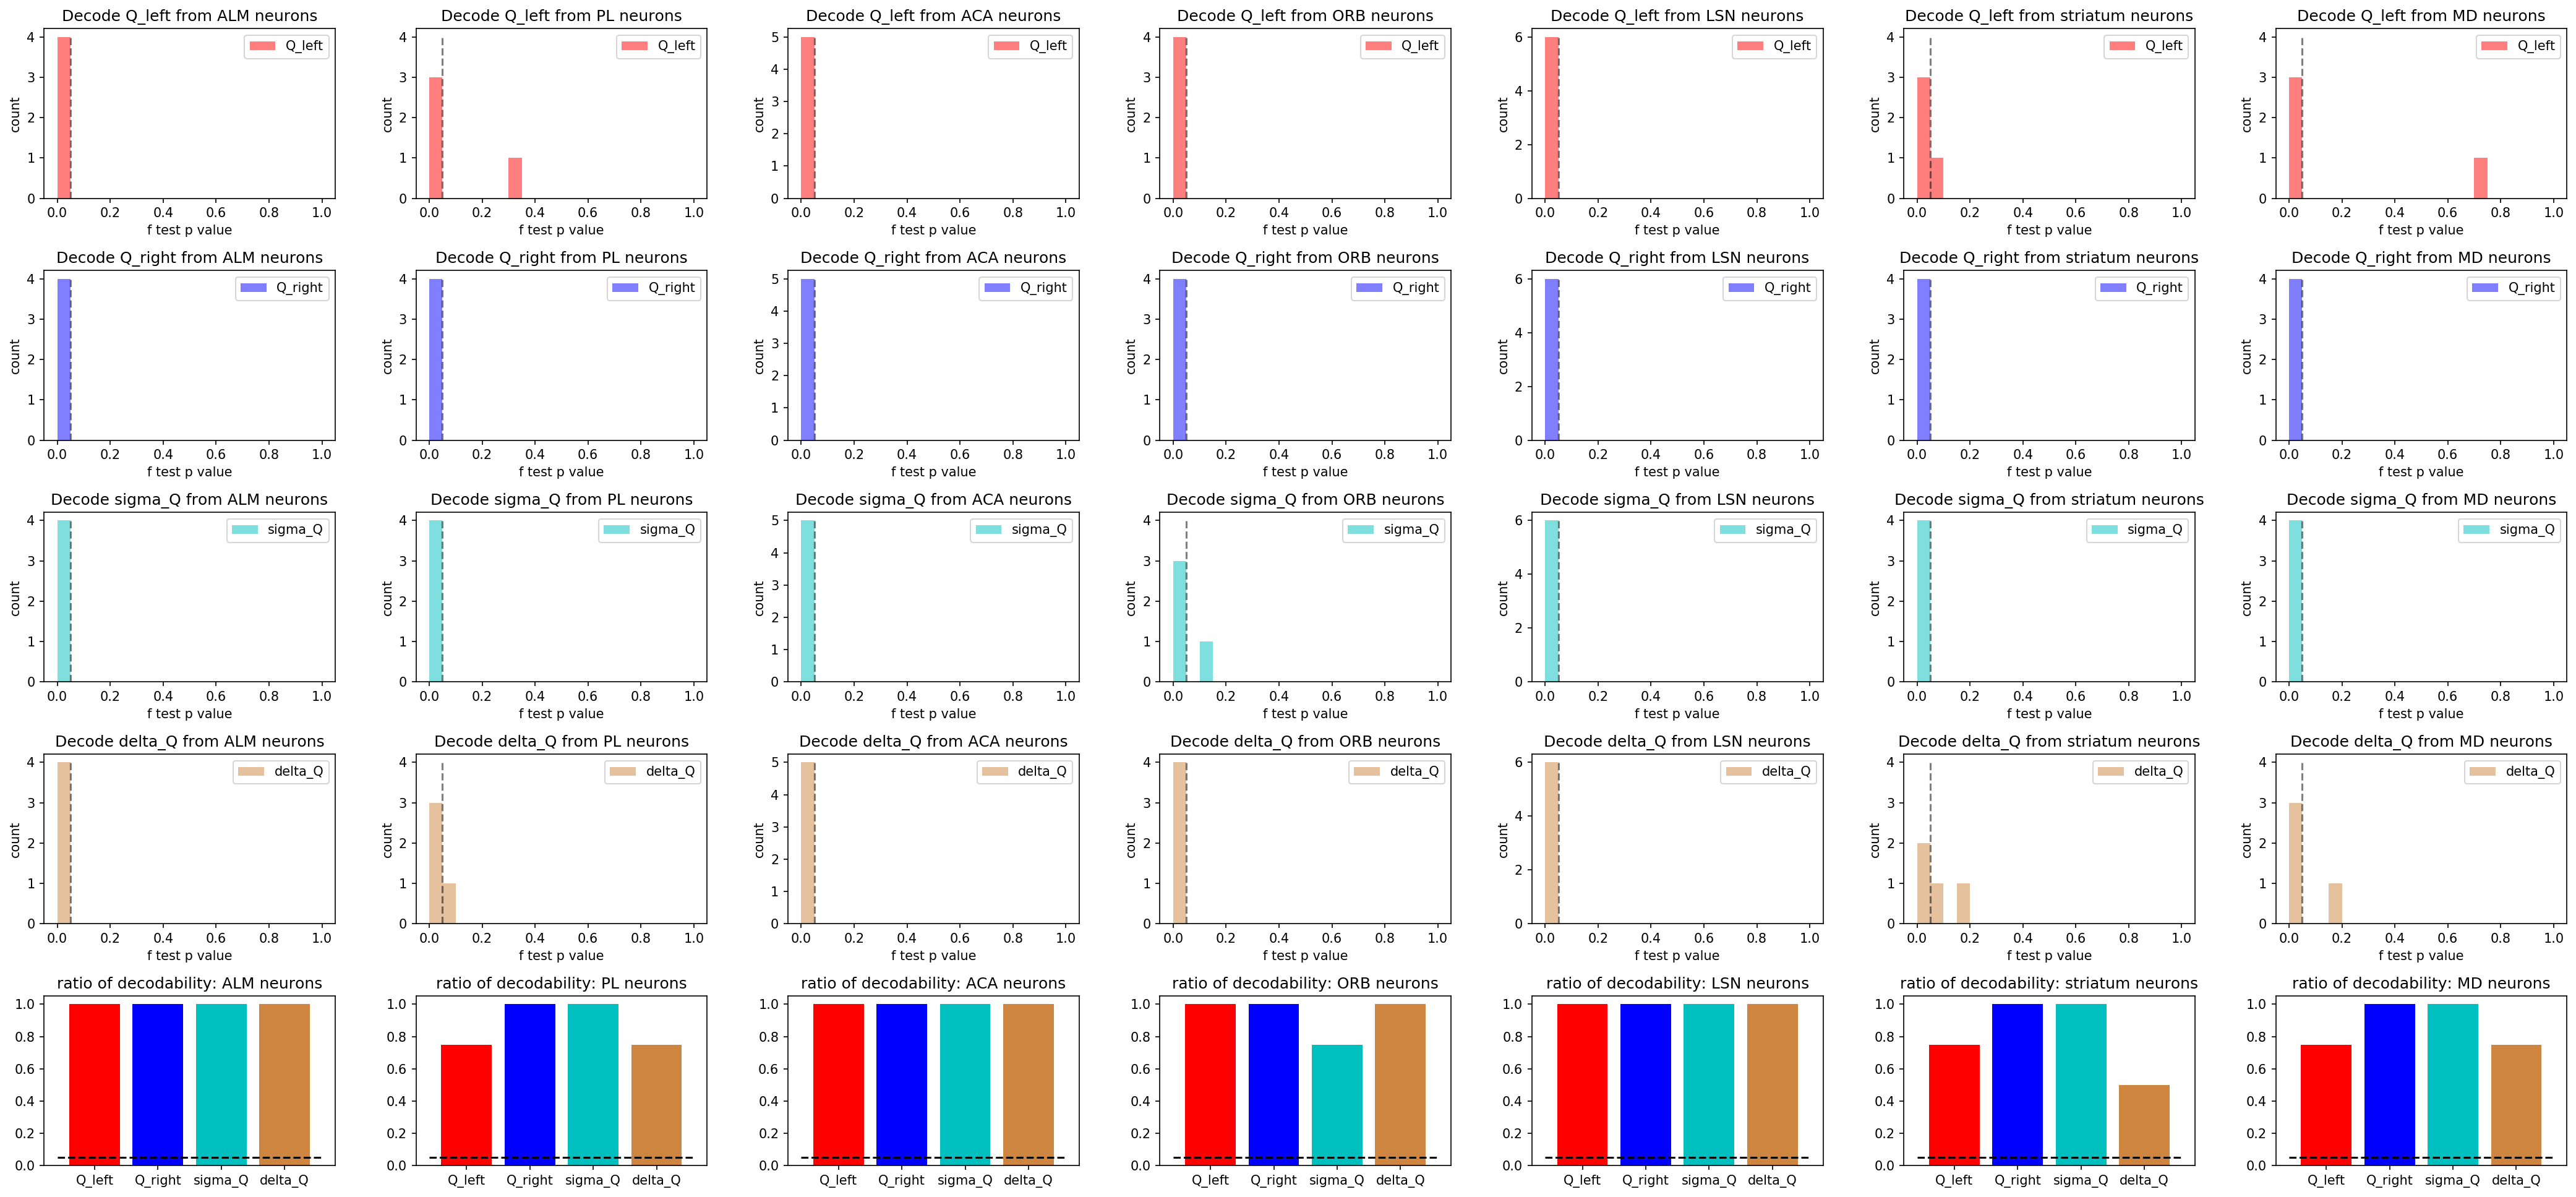

In [14]:
# plot std fit, poppulation decoding
# plot std fit, single neuron decoding

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05

# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*len(target_variables)+1),
                        dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_std_decode_pop_dict[region]
    n_sessions = len(np.unique(df_fit['src_session'].values))

    n_sig_sessions = {target_variable: None for target_variable in target_variables}
    for i, target_variable in enumerate(target_variables):
        
        # histogram of regression tvalues
        row_ind = i
        ftest_pvalues = df_fit[df_fit['target_variable']==target_variable]['ftest_pvalue'].values
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues, bins=20, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                       color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(pvalue_sig_thresh, 0, n_sessions, 
                                     color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {region} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_sessions[target_variable] = np.sum(ftest_pvalues < 0.05)

    
    # bar plot for significant neurons
    row_ind = len(target_variables)
    classified_ratios = [n_sig_sessions[target_variable]/ float(n_sessions) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decodability: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1.05)

plt.tight_layout()

### multi-sessinon PERMUTATION analysis

In [ ]:
# msp fit, single neuron encoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# plot msp fit, single neuron encoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# msp fit, single neuron decoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# plot msp fit, single neuron decoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# msp fit, poppulation decoding
# msp fit, poppulation decoding
# compute the test statistic: sum of residuals from regression models
# in all possible permutations


regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']

msp_decode_pop_columns = ['gen_session_perm', 'fit_session_perm', 'target_variable', 'residuals', 'mse_total']
df_msp_decode_pop_dict = {region: pd.DataFrame(columns=msp_decode_pop_columns) for region in regions_to_fit}


# fit on all permutations of sessions
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    # calculate minimal session length
    sess_min_len = 100000
    for sess in sessions_with_unit:
        df_Qs_sess = df_Qs[df_Qs['session']==sess].sort_values(by=['trial'])
        sess_len = len(df_Qs_sess)
        sess_min_len = min(sess_min_len, sess_len)
    print(f' min session length: {sess_min_len}')

    df_msp_fit = df_msp_decode_pop_dict[region]


    for j, p in enumerate(itertools.permutations(range(len(sessions_with_unit)))):
        print(f'  permutation {j}: {p}')
    
        for target_variable in target_variables:
            gen_session_perm = []
            fit_session_perm = []
            residuals = []
            mse_total = []

            for session_id in range(len(sessions_with_unit)):
                gen_session = sessions_with_unit[session_id]
                fit_session = sessions_with_unit[p[session_id]]
                gen_session_perm.append(gen_session)
                fit_session_perm.append(fit_session)
                # print(f' using gen_session {gen_session} and fit_session {fit_session}')

                # get population activity
                neurons_region_session = neurons_region[neurons_region['session']==gen_session]
                fr = np.empty((sess_min_len, 
                               len(neurons_region_session)))
                for j in range(len(neurons_region_session)):
                    fr[:, j] = neurons_region_session.iloc[j]['firing_rates'][:sess_min_len]
                fr = sm.add_constant(fr)
                #print(f'  sess {gen_session} fr shape {fr.shape}')

                # get Qs
                df_Qs_session = df_Qs[df_Qs['session']==fit_session].sort_values(by=['trial'])
                if target_variable in ['Q_left', 'Q_right']:
                    X = df_Qs_session[[target_variable]][:sess_min_len]
                elif target_variable == 'sigma_Q':
                    X = (df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values)[:sess_min_len]
                elif target_variable == 'delta_Q':
                    X = (df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values)[:sess_min_len]
                else:
                    raise ValueError('incorrect target variable type!')

                # decoding models: fr --> X
                model = sm.OLS(X, fr)
                results = model.fit()
                #print(f'{neuron_type} {n} {target_variable}')
                #print(f' {results.f_pvalue}')
                residuals.append(results.resid)
                mse_total.append(results.mse_total)
            
            residuals = np.array(residuals)
            mse_total = np.array(mse_total)
            df_msp_fit.loc[len(df_msp_fit.index)] = [gen_session_perm, fit_session_perm, 
                                                    target_variable, residuals, mse_total]

In [ ]:
# save the msp population decoding df if not existed
#with open('./ephys_msp_decode_pop.pickle', 'wb') as handle:
#    pickle.dump(df_msp_decode_pop_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
raw_res = df_msp_decode_pop_dict['ALM'][df_msp_decode_pop_dict['ALM']['target_variable']=='Q_left']['residual'].values

10.740473712770637

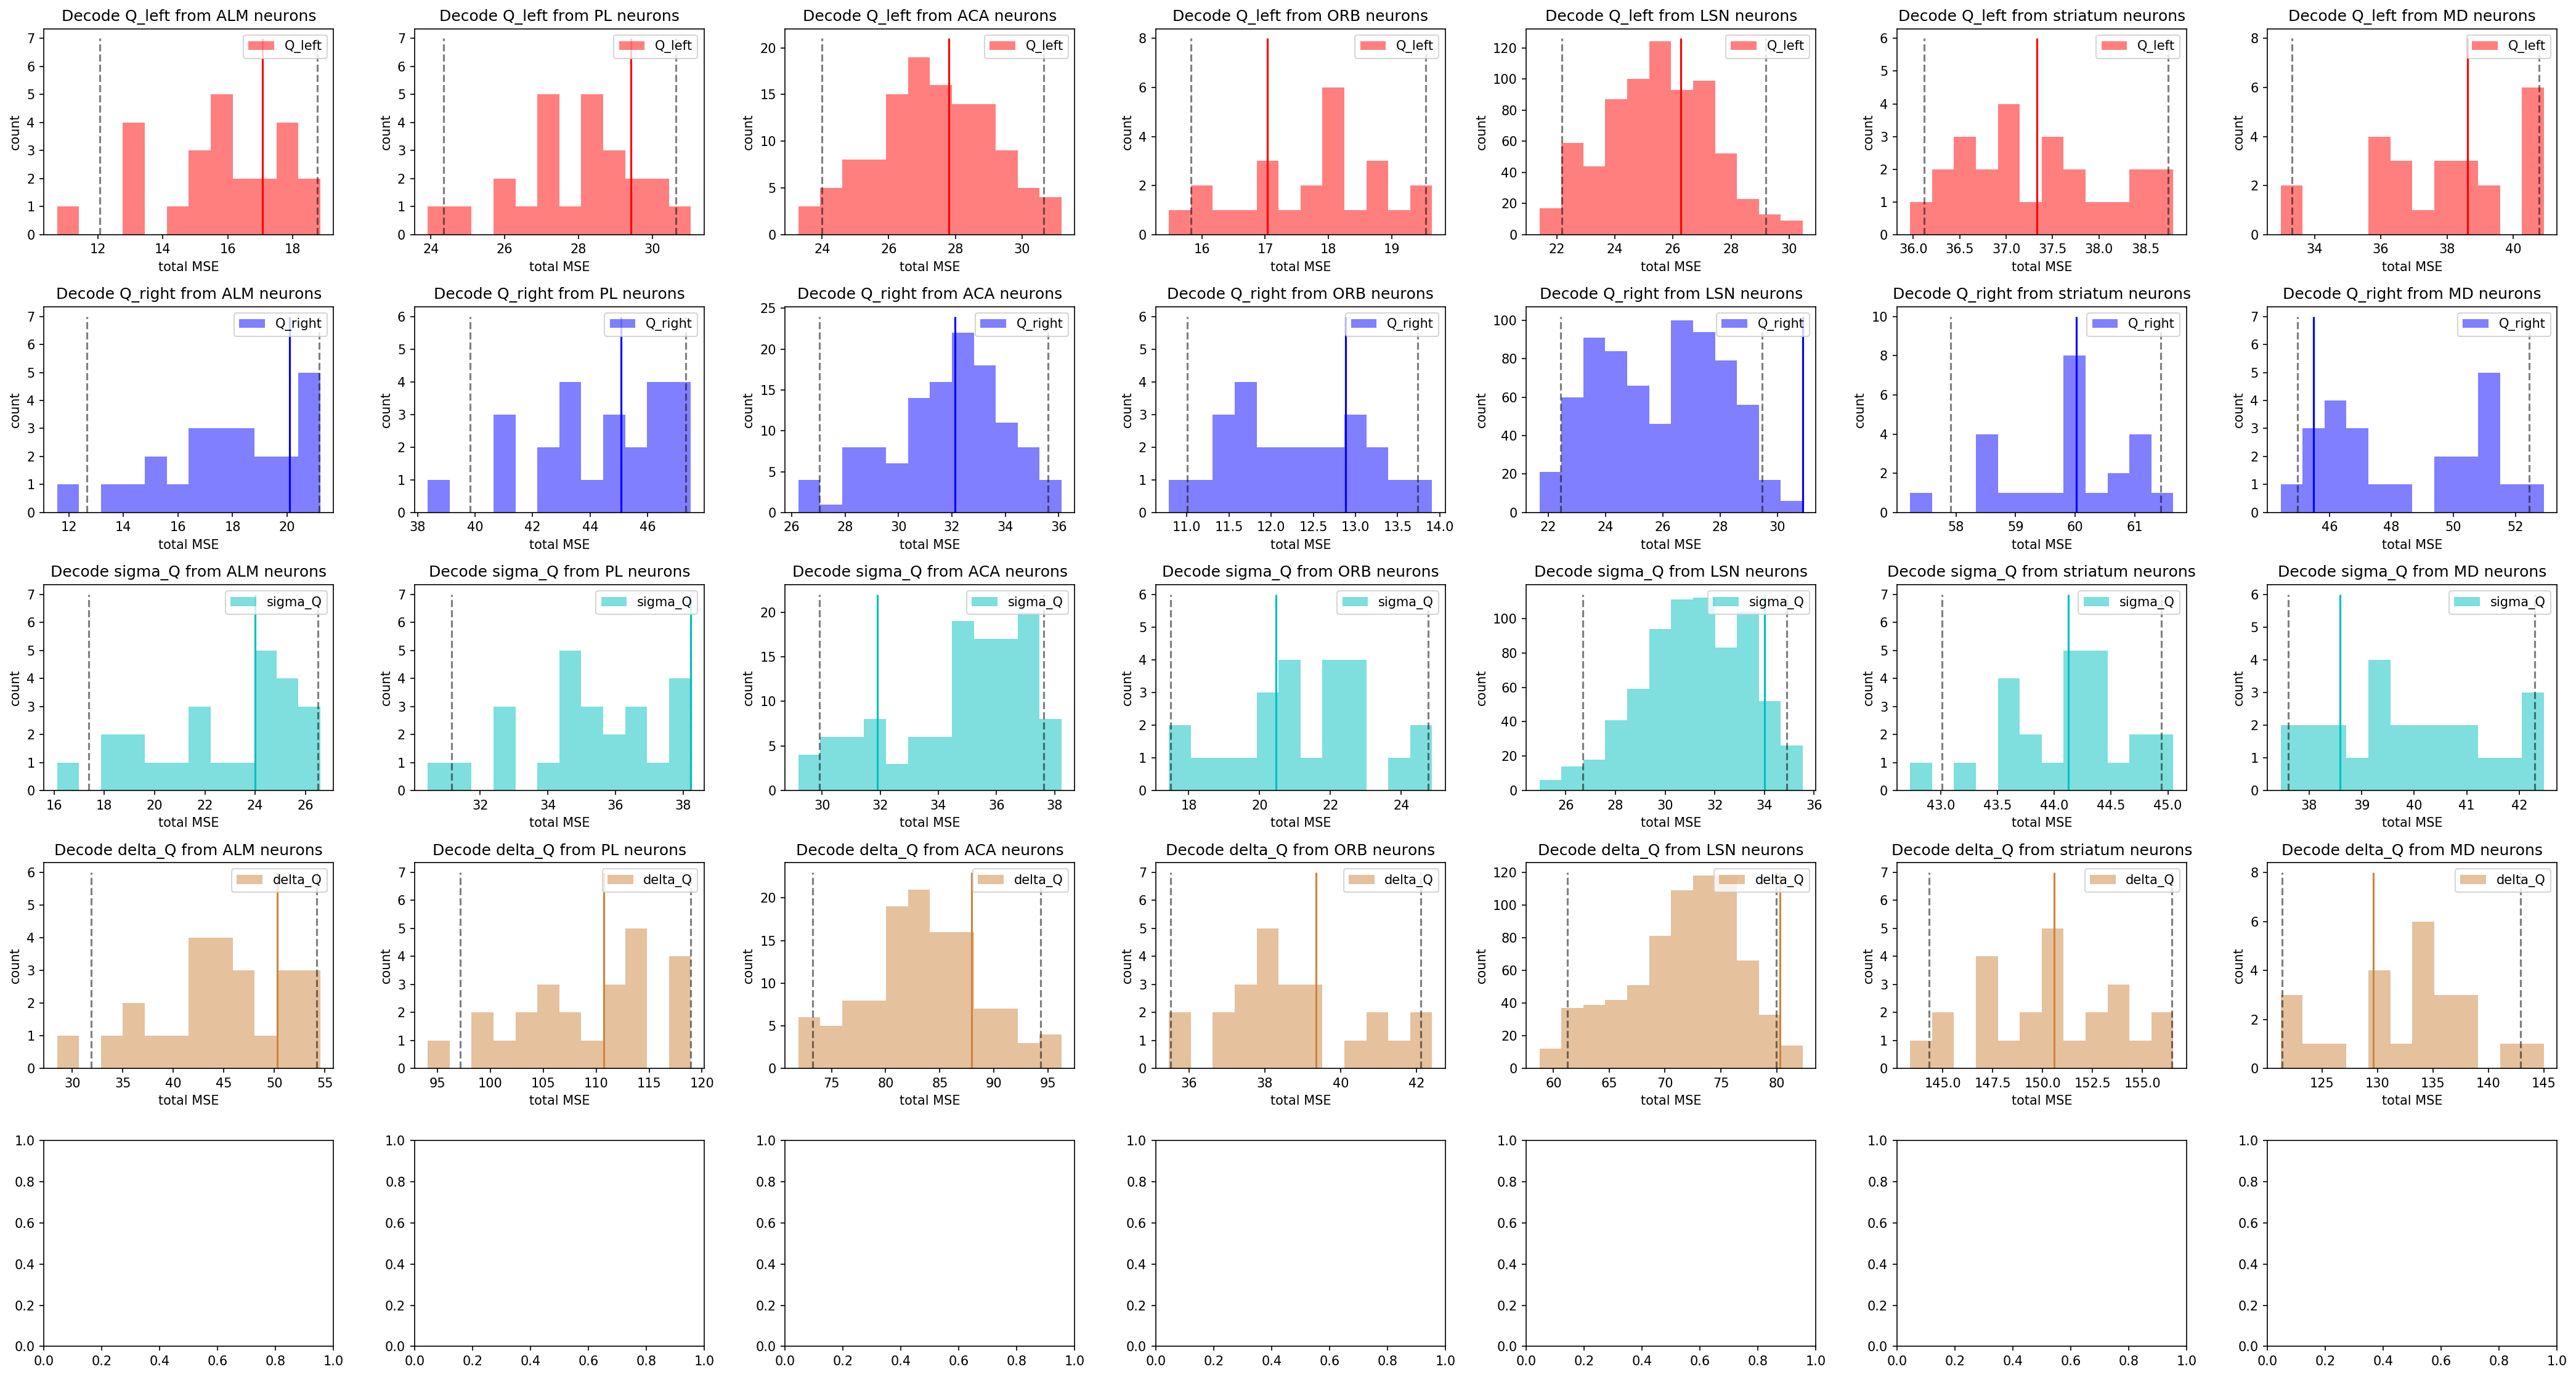

In [62]:
# plot msp fit, poppulation decoding
# plot ps fit, poppulation decoding

with open('./ephys_msp_decode_pop.pickle', 'rb') as handle:
    df_msp_decode_pop_dict = pickle.load(handle)

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
percentiles_2_compute = [2.5, 97.5]

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*len(target_variables)),
                        dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_msp_decode_pop_dict[region]

    for i, target_variable in enumerate(target_variables):
        df_fit_tv = df_fit[df_fit['target_variable']==target_variable]
        # get total errors
        total_errors = []
        raw_residuals = df_fit_tv['residuals'].values
        for raw_residual in raw_residuals:
            total_errors.append(np.sum(np.sum(np.square(raw_residual), axis=1)))
        total_errors = np.array(total_errors)
        
        # get self fitted total error
        raw_residual_self = df_fit_tv[df_fit_tv['gen_session_perm']==df_fit_tv['fit_session_perm']].iloc[0]['residuals']
        total_error_self = np.sum(np.sum(np.square(raw_residual), axis=1))
        
        total_errors_percentile = np.percentile(total_errors, percentiles_2_compute)
        total_error_self_percentile = stats.percentileofscore(total_errors, total_error_self)

        # histogram of regression tvalues
        row_ind = i
        hist_tv, _, _ = axs[row_ind, col_ind].hist(total_errors, bins=12, histtype='stepfilled', 
                                                   color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(total_errors_percentile, 0, np.max(hist_tv)+2,
                                     color='k', linestyle='--', alpha=0.5)
        axs[row_ind, col_ind].vlines(total_error_self, 0, np.max(hist_tv)+2,
                                     color=colors[target_variable])
        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {region} neurons')
        axs[row_ind, col_ind].set_xlabel('total MSE')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

plt.tight_layout()

### Pseudo-session analysis

In [12]:
def get_block_lengths(p_reward_trial, p_reward_block):
    block_switch_trial = [0]
    for block_ind in range(p_reward_block.shape[1]):
        trials = np.where((p_reward_trial[0] == p_reward_block[0, block_ind]) & 
                          (p_reward_trial[1] == p_reward_block[1, block_ind]) &
                          [False if t<block_switch_trial[-1] else True for t in range(p_reward_trial.shape[1])])[0]
        # print(f'{block_ind}: {trials}')
        # print(f' {np.where(np.diff(trials) > 1)}')
        if len(np.where(np.diff(trials) > 1)[0])>0:
            trials_first_switch_ind = np.where(np.diff(trials) > 1)[0][0] + 1
            block = trials[: trials_first_switch_ind]
        else:
            block = trials
        # print(f' {block}')
        block_switch_trial.append(block[-1]+1)
    
    block_switch_trial = np.array(block_switch_trial)
    block_lengths = np.diff(block_switch_trial)

    return block_lengths, block_switch_trial


def gen_p_reward_same_block_struct(p_reward_trial, p_reward_block, block_lengths, 
                          block_generator_spread=5, seed=None, plot=False):
    
    p_reward_gen = np.empty((p_reward_trial.shape[0], p_reward_trial.shape[1]+1))
    #print(f'p_reward_block shape: {p_reward_block.shape}')
    #print(f'p_reward_gen shape: {p_reward_gen.shape}')

    # generate new block lengths
    if seed:
        np.random.seed(seed)
    
    not_all_positive = True
    while not_all_positive:
        block_length_generator = np.rint(np.random.uniform(
                                            -1*block_generator_spread+0.1, 
                                            block_generator_spread+0.1, 
                                            size=len(block_lengths)-1)).astype(np.int)
        block_length_generator = np.append(block_length_generator, -1*np.sum(block_length_generator))
        block_lengths_gen = (block_lengths + block_length_generator).astype(np.int)
        not_all_positive = np.any(block_lengths_gen<=0)
        
    #print(f'original block lengths: {block_lengths}')
    #print(f'generated new block length: {block_lengths_gen}')
    #print(f'check total trial number: {np.sum(block_lengths_gen)}')
    
    # generate new p_reward arr
    for i in range(p_reward_trial.shape[0]):
        for block_gen_ind in range(len(block_lengths_gen)):
            if block_gen_ind == 0:
                p_reward_gen[i, 0:block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
            else:
                t_start = np.sum(block_lengths_gen[:block_gen_ind])
                p_reward_gen[i, t_start:t_start+block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
        p_reward_gen[i, -1] = p_reward_gen[i, -2]

    if plot:
        sides = ['left', 'right']
        colors = ['r', 'b']
        plt.figure(figsize=(8,4), dpi=150)
        for i in range(p_reward_trial.shape[0]):
            plt.plot(p_reward_trial[i], color=colors[i], label=f'original {sides[i]}')
            plt.plot(p_reward_gen[i], color=colors[i], linestyle='--', label=f'generated {sides[i]}')
            plt.title(f'Generated reward rate blocks')
            plt.xlabel('trial')
            plt.ylabel('reward_rate')
        plt.legend(bbox_to_anchor=(1, 0.6))
        plt.tight_layout()
            
    return p_reward_gen, block_lengths_gen


def gen_qs_by_fitted_model(key, n_trials, forager_type='LNP_softmax', gen_type='random_block_struct',
                           p_reward_trial=None, p_reward_block=None, block_lengths=None, 
                           block_generator_spread=5):
    
    # gen_type: ['random_block_struct', 'same_block_struct']
    # by default: random_block_struct

    # get fitted model
    model_para = pd.DataFrame((foraging_model.FittedSessionModel.Param & key).fetch())
    model_para_dict = {}
    for i in range(len(model_para)):
        model_para_dict[model_para.iloc[i]['model_param']] = model_para.iloc[i]['fitted_value']
        
    forager = bandit_model.BanditModel(forager=forager_type, n_trials=n_trials, 
                                       **model_para_dict)
    #for k, v in vars(forager).items():
    #    if v is not None:
    #        print(f'{k}: {v}')
    if gen_type == 'random_block_struct':
        forager.generate_p_reward()
        #print('simulating forager')
        forager.simulate()
    
    
    elif gen_type == 'same_block_struct':
        # generate reward sequence
        p_reward_gen, block_lengths_gen = gen_p_reward_same_block_struct(p_reward_trial, p_reward_block, block_lengths, 
                                            block_generator_spread=block_generator_spread, plot=False)
        forager.n_blocks = len(block_lengths)
        forager.p_reward = p_reward_gen
        forager.block_size = block_lengths_gen
        forager.p_reward_fraction = p_reward_gen[1]/ np.sum(p_reward_gen, axis=0)
        forager.p_reward_ratio = p_reward_gen[1]/ p_reward_gen[0]

        # generative mode
        # Initialization
        forager.time = 0

        # All latent variables have n_trials + 1 length to capture the update after the last trial (HH20210726)
        forager.q_estimation = np.full([forager.K, forager.n_trials+1], np.nan)
        forager.q_estimation[:, 0] = 0

        forager.choice_prob = np.full([forager.K, forager.n_trials+1], np.nan)
        forager.choice_prob[:, 0] = 1/forager.K   # To be strict (actually no use)

        forager.choice_history = np.zeros(
                        [1, forager.n_trials+1], dtype=int)  # Choice history
        # Reward history, separated for each port (Corrado Newsome 2005)
        forager.reward_history = np.zeros([forager.K, forager.n_trials+1])

        forager.reward_available = np.zeros([forager.K, forager.n_trials+1])
        forager.reward_available[:, 0] = (np.random.uniform(0, 1, forager.K) < forager.p_reward[:, forager.time]).astype(int)

        if forager.forager in ['LNP_softmax', 'LNP_softmax_CK']:
            # Compute the history filter. Compatible with any number of taus.
            # Use the full length of the session just in case of an extremely large tau.
            reversed_t = np.flipud(np.arange(forager.n_trials+1))
            forager.history_filter = np.zeros_like(reversed_t).astype('float64')
            for tau, w_tau in zip(forager.taus, forager.w_taus):
                # Note the normalization term (= tau when n -> inf.)
                forager.history_filter += w_tau * \
                                        np.exp(-reversed_t / tau) / \
                                        np.sum(np.exp(-reversed_t / tau))

        for t in range(forager.n_trials):
            action = forager.act()
            forager.step(action)
    
    else:
        raise ValueError('wrong gen_type for q generation')

    return forager.q_estimation


mouses = {
    'ALM': 'HH13', #sess=4
    'PL': 'HH08', #sess=4
    'ACA': 'HH13', #sess=5
    'ORB': 'HH09', #sess=4
    'LSN': 'HH13', #sess=6
    'striatum': 'HH08', #sess=5
    'MD': 'HH09' #sess=4
}

In [15]:
# generate pseudo sessions (pseudo Qs)
n_pseudo_sessions_pool = 360

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']

ps_encode_columns = ['src_session', 'gen_id', 'q_pseudo']
pseudo_sessions_dict = {region: pd.DataFrame(columns=ps_encode_columns) for region in regions_to_fit}


for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]

    mouse = mouses[region]
    subject_id = (lab.WaterRestriction & f'water_restriction_number="{mouse}"').fetch('subject_id')[0]

    df_pseudo_sessions = pseudo_sessions_dict[region]

    for session in sessions_with_unit:
        # get session history
        key = {'subject_id': subject_id, 
               'session': session, 
               'model_id': 10}
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        n_trials = len(df_Qs_session)
        print(f' session {session}: {n_trials}')
        
        # generate pseudo-sessions
        print(' generating pseudo sessions pool')
        q_pseudo_sessions = []
        for j in range(n_pseudo_sessions_pool):
            q_pseudo_session = gen_qs_by_fitted_model(key, n_trials).T[:-1, :]
            df_pseudo_sessions.loc[len(df_pseudo_sessions.index)] = [session, j, q_pseudo_session]

region ALM


/home/map/.local/lib/python3.6/site-packages/datajoint/connection.py:219: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


 session 33: 586
 generating pseudo session pool
 session 34: 379
 generating pseudo session pool
 session 36: 450
 generating pseudo session pool
 session 37: 321
 generating pseudo session pool
region PL
 session 49: 748
 generating pseudo session pool
 session 50: 634
 generating pseudo session pool
 session 51: 594
 generating pseudo session pool
 session 52: 543
 generating pseudo session pool
region ACA
 session 33: 586
 generating pseudo session pool
 session 34: 379
 generating pseudo session pool
 session 36: 450
 generating pseudo session pool
 session 37: 321
 generating pseudo session pool
 session 43: 791
 generating pseudo session pool
region ORB
 session 46: 277
 generating pseudo session pool
 session 47: 421
 generating pseudo session pool
 session 48: 178
 generating pseudo session pool
 session 50: 272
 generating pseudo session pool
region LSN
 session 33: 586
 generating pseudo session pool
 session 34: 379
 generating pseudo session pool
 session 36: 450
 generati

In [16]:
# save the pseudo session df if not existed
with open('./pseudo_sessions_match.pickle', 'wb') as handle:
    pickle.dump(pseudo_sessions_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# ps fit, single neuron encoding
# compute the test statistic: t values of regression with q generation
# generating pseudo sessions (pseudo Qs)

#with open('./pseudo_sessions_match.pickle', 'rb') as handle:
#    pseudo_sessions_dict = pickle.load(handle)

n_pseudo_sessions = 120
n_pseudo_sessions_pool = 360

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']

ps_encode_columns = ['src_session', 'unit', 'fit_session', 'tvalues_Q_left', 'tvalues_Q_right']
df_ps_encode_dict = {region: pd.DataFrame(columns=ps_encode_columns) for region in regions_to_fit}


# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    df_pseudo_sessions = pseudo_sessions_dict[region]

    df_ps_fit = df_ps_encode_dict[region]

    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]

        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        n_trials = len(df_Qs_session)
        print(f' session {session}: {n_trials}')
        X = df_Qs_session[['Q_left', 'Q_right']]
        X = sm.add_constant(X)

        df_pseudo_sessions_session = df_pseudo_sessions[df_pseudo_sessions['src_session']==session]
        
        for unit in np.unique(neurons_region_session['unit'].values):
            fr = neurons_region_session[(neurons_region_session['unit']==unit)].iloc[0]['firing_rates']
            
            # fit true session
            model = sm.OLS(fr, X)
            results = model.fit()
            df_ps_fit.loc[len(df_ps_fit.index)] = [session, unit, session, 
                                                   results.tvalues['Q_left'], 
                                                   results.tvalues['Q_right']]

            # fit pseudo sessions
            df_pseudo_sessions_session_unit = df_pseudo_sessions_session.sample(n=n_pseudo_sessions)
            for _, row in df_pseudo_sessions_session_unit.iterrows():
                X_pseudo = row['q_pseudo']
                X_pseudo = sm.add_constant(X_pseudo)
                model = sm.OLS(fr, X_pseudo)
                results = model.fit()
                df_ps_fit.loc[len(df_ps_fit.index)] = [session, unit, -1*(row['gen_id']),
                                                       results.tvalues[1], 
                                                       results.tvalues[2]]

region ALM
 session 33: 586
 session 34: 379
 session 36: 450
 session 37: 321
region PL
 session 49: 748
 session 50: 634
 session 51: 594
 session 52: 543
region ACA
 session 33: 586
 session 34: 379
 session 36: 450
 session 37: 321
 session 43: 791
region ORB
 session 46: 277
 session 47: 421
 session 48: 178
 session 50: 272
region LSN
 session 33: 586
 session 34: 379
 session 36: 450
 session 37: 321
 session 42: 1142
 session 43: 791
region striatum
 session 49: 748
 session 50: 634
 session 51: 594
 session 52: 543
region MD
 session 57: 359
 session 58: 262
 session 59: 342
 session 60: 736


In [20]:
# save the ps encoding df if not existed
with open('./ephys_ps_encode.pickle', 'wb') as handle:
    pickle.dump(df_ps_encode_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

ALM total dots: 315
 classified Q_left: 52
 classified Q_right: 33
 classified sigma_Q: 9
 classified delta_Q: 2
PL total dots: 189
 classified Q_left: 33
 classified Q_right: 14
 classified sigma_Q: 11
 classified delta_Q: 0
ACA total dots: 248
 classified Q_left: 43
 classified Q_right: 15
 classified sigma_Q: 1
 classified delta_Q: 0
ORB total dots: 311
 classified Q_left: 37
 classified Q_right: 33
 classified sigma_Q: 6
 classified delta_Q: 1
LSN total dots: 416
 classified Q_left: 31
 classified Q_right: 11
 classified sigma_Q: 2
 classified delta_Q: 0
striatum total dots: 66
 classified Q_left: 5
 classified Q_right: 6
 classified sigma_Q: 3
 classified delta_Q: 0
MD total dots: 72
 classified Q_left: 15
 classified Q_right: 4
 classified sigma_Q: 10
 classified delta_Q: 0


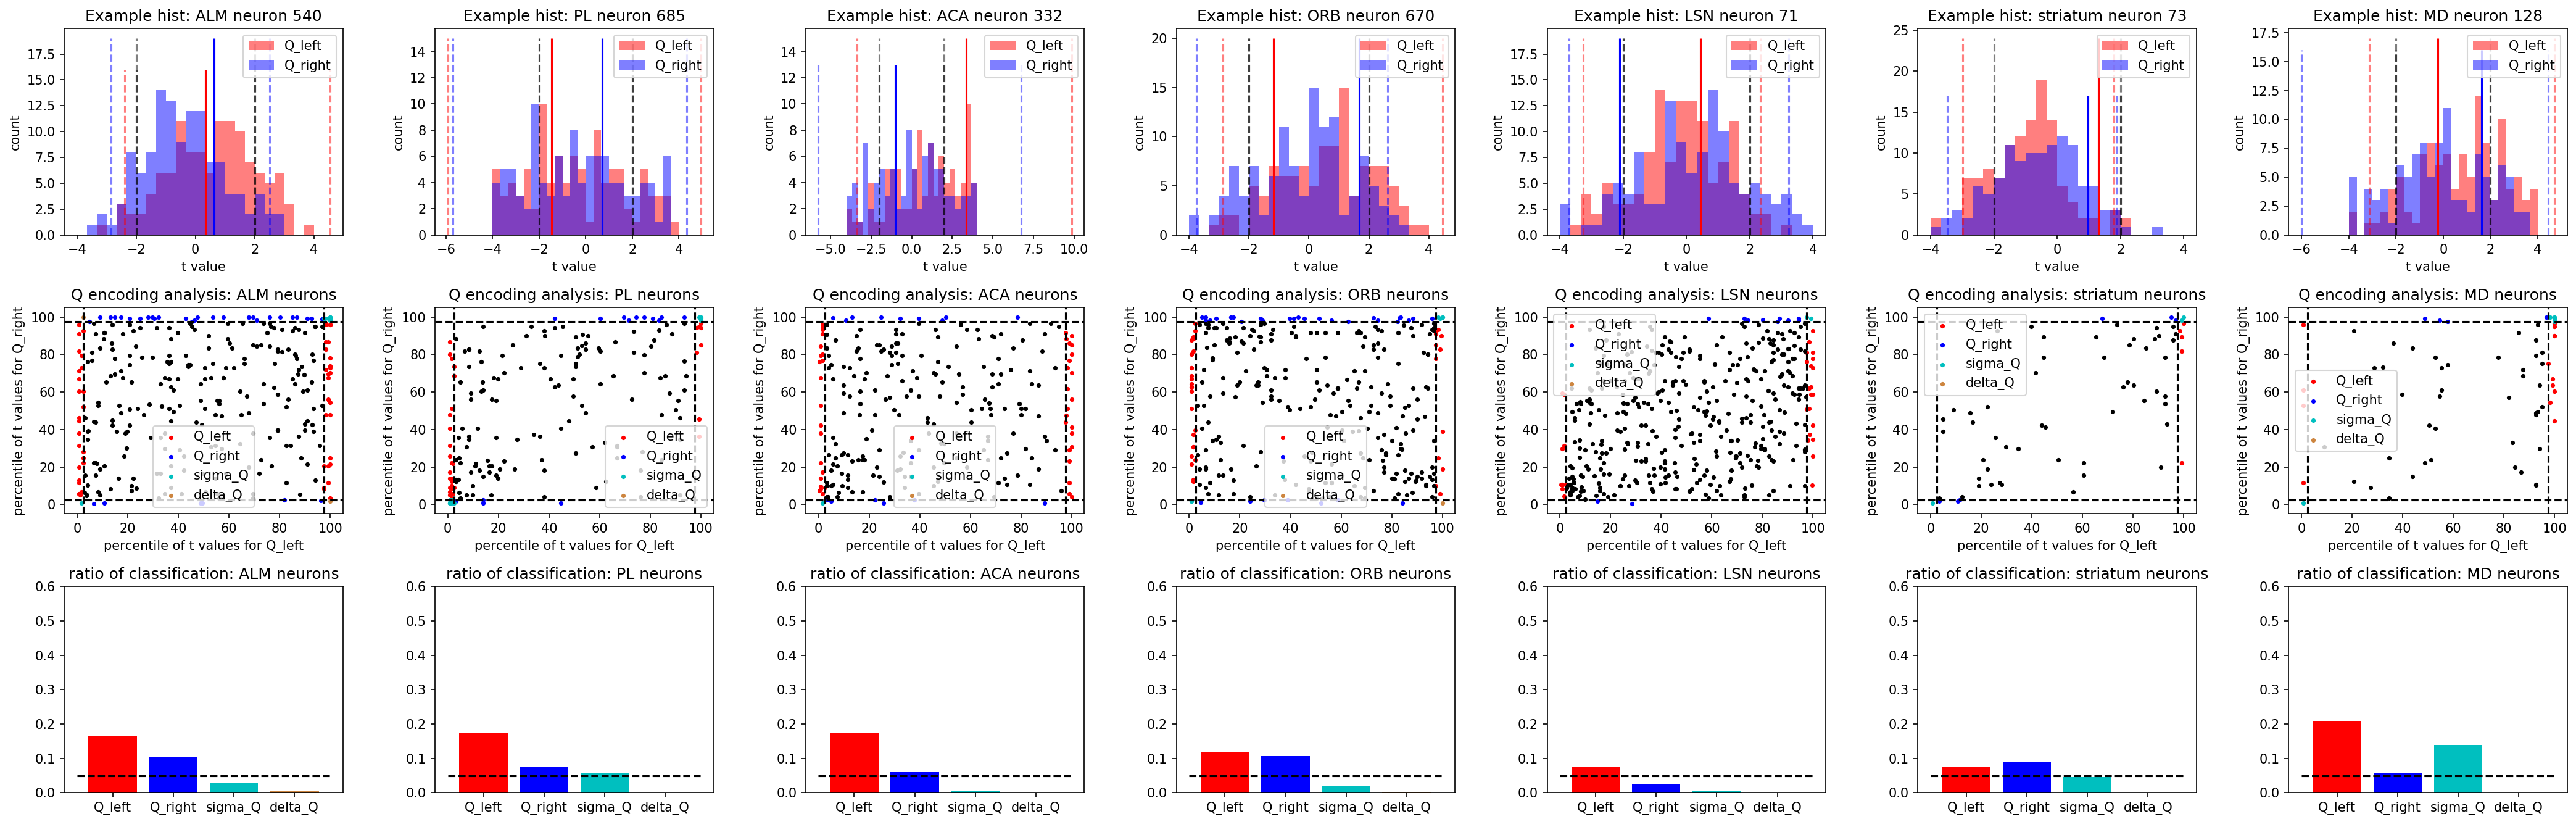

In [21]:
# plot ps fit, single neuron encoding

#with open('./ephys_ps_encode.pickle', 'rb') as handle:
#    df_ps_encode_dict = pickle.load(handle)

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
percentiles_2_compute = [2.5, 97.5]

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b'}
hist_lim = (-4, 4)
# scatter plot
tvalue_percentile_lim = (-5, 105)
tvalue_sig_thresh = (-2, 2)
dot_size = 6
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(3, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*3), dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_ps_encode_dict[region]

    # calculate percentile of t values of self-fitted sessions
    # based on the ensemble of pseudo sessions
    n_neurons_fitted = len(np.unique(df_fit['unit'].values))
    df_fit_t_percentile_agnt_null = pd.DataFrame(columns=['unit', 'Q_left', 'Q_right'])
    
    hist_to_plot_neuron = np.random.choice(np.unique(df_fit['unit'].values).astype(np.int))

    for n in np.unique(df_fit['unit'].values).astype(np.int):
        df_fit_neuron = df_fit[df_fit['unit']==n]
        t_percentile_agnt_null = [n]

        for i, q_side in enumerate(['Q_left', 'Q_right']):
            tvalues_q_side = df_fit_neuron[f'tvalues_{q_side}'].values
            
            # get self fitted t values
            tvalue_self_q_side = df_fit_neuron[df_fit_neuron['src_session']==df_fit_neuron['fit_session']].iloc[0][f'tvalues_{q_side}']
            tvalues_percentile_q_side = np.percentile(tvalues_q_side, percentiles_2_compute)
            
            t_percentile_agnt_null.append(stats.percentileofscore(tvalues_q_side, tvalue_self_q_side))

            # histogram of regression tvalues
            if n == hist_to_plot_neuron:
                row_ind = 0
                tvalues_percentile_q_side = np.percentile(tvalues_q_side, percentiles_2_compute)
                hist_q_side, _, _ = axs[row_ind, col_ind].hist(tvalues_q_side, bins=24, range=hist_lim, histtype='stepfilled', 
                                                            color=colors[q_side], label=q_side, alpha=0.5)
                axs[row_ind, col_ind].vlines(tvalue_self_q_side, 0, np.max(hist_q_side)+5, 
                                             color=colors[q_side])
                axs[row_ind, col_ind].vlines(tvalues_percentile_q_side, 0, np.max(hist_q_side)+5, 
                                             color=colors[q_side], linestyle='--', alpha=0.5)
                axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_side)+5, 
                                             color='k', linestyle='--', alpha=0.5)
                axs[row_ind, col_ind].set_title(f'Example hist: {region} neuron {n}')
                axs[row_ind, col_ind].set_xlabel('t value')
                axs[row_ind, col_ind].set_ylabel('count')
                axs[row_ind, col_ind].legend()

        df_fit_t_percentile_agnt_null.loc[len(df_fit_t_percentile_agnt_null.index)] = t_percentile_agnt_null
    

    # scatter plot of neurons
    row_ind = 1
    # choose tvalue_sig_threshold
    # (-2, 2) for naive case
    # tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 'Q_right': tvalue_sig_thresh} 
    # dynamic for adv analysis
    # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
    # (2.5, 97.5) for percentile case
    tvalue_sig_threshold = {'Q_left': percentiles_2_compute, 'Q_right': percentiles_2_compute} 

    df_fit_Q_left_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                (df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                               (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                               (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_left_sig['Q_left'].values, 
                                  df_fit_Q_left_sig['Q_right'].values, 
                                  color='r', s=dot_size, label='Q_left')
    df_fit_Q_right_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_right_sig['Q_left'].values, 
                                  df_fit_Q_right_sig['Q_right'].values, 
                                  color='b', s=dot_size, label='Q_right')
    df_fit_sigma_Q_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
    axs[row_ind, col_ind].scatter(df_fit_sigma_Q_sig['Q_left'].values, 
                                  df_fit_sigma_Q_sig['Q_right'].values, 
                                  color='c', s=dot_size, label='sigma_Q')
    df_fit_delta_Q_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
    axs[row_ind, col_ind].scatter(df_fit_delta_Q_sig['Q_left'].values, 
                                  df_fit_delta_Q_sig['Q_right'].values, 
                                  color='peru', s=dot_size, label='delta_Q')
    df_fit_null = df_fit_t_percentile_agnt_null[(df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                         (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                         (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                         (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_null['Q_left'].values, 
                                  df_fit_null['Q_right'].values, 
                                  color='k', s=dot_size)
    sum_classified_neurons = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                             len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                             len(df_fit_null)
    if len(df_fit_t_percentile_agnt_null) != sum_classified_neurons:
        raise ValueError(f'sum of dots doesnt match: {len(df_fit_t_percentile_agnt_null)} {sum_classified_neurons}')

    axs[row_ind, col_ind].hlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].vlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'Q encoding analysis: {region} neurons')
    axs[row_ind, col_ind].set_xlim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
    axs[row_ind, col_ind].set_ylim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
    axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
    axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
    axs[row_ind, col_ind].legend()


    # bar plot for significant neurons
    row_ind = 2
    
    print(f'{region} total dots: {len(df_fit_t_percentile_agnt_null)}')
    print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
    print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
    print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
    print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
    classified_ratios = [
        len(df_fit_Q_left_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_Q_right_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_sigma_Q_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_delta_Q_sig)/ float(len(df_fit_t_percentile_agnt_null))]
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 0.6)

plt.tight_layout()

In [ ]:
# ps fit, single neuron decoding
# compute the test statistic: t values of regression with q generation
# generating pseudo sessions (pseudo Qs)

n_pseudo_sessions = 120
n_pseudo_sessions_pool = 360

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']

ps_decode_columns = ['src_session', 'unit', 'fit_session', 'target_variable', 'ftest_pvalue']
df_ps_decode_dict = {region: pd.DataFrame(columns=ps_decode_columns) for region in regions_to_fit}


# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    df_pseudo_sessions = pseudo_sessions_dict[region]

    df_ps_fit = df_ps_decode_dict[region]


    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]

        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        n_trials = len(df_Qs_session)
        print(f' session {session}: {n_trials}')

        df_pseudo_sessions_session = df_pseudo_sessions[df_pseudo_sessions['src_session']==session]


        for target_variable in target_variables:
            # get true session
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            #print(f' sess {session}, target {target_variable}: {X.shape}')

            for unit in np.unique(neurons_region_session['unit'].values):
                fr = neurons_region_session[(neurons_region_session['unit']==unit)].iloc[0]['firing_rates']
                fr = sm.add_constant(fr)

                # fit true session
                # decoding models: fr --> X
                model = sm.OLS(X, fr)
                results = model.fit()
                df_ps_fit.loc[len(df_ps_fit.index)] = [session, unit, session, 
                                                       target_variable, 
                                                       results.f_pvalue]

                # fit pseudo sessions
                df_pseudo_sessions_session_unit = df_pseudo_sessions_session.sample(n=n_pseudo_sessions)
                for _, row in df_pseudo_sessions_session_unit.iterrows():
                    X_pseudo = row['q_pseudo']
                    if target_variable == 'Q_left':
                        X_pseudo = X_pseudo[:, 0]
                    elif target_variable == 'Q_right':
                        X_pseudo = X_pseudo[:, 1]
                    elif target_variable == 'sigma_Q':
                        X_pseudo = X_pseudo[:, 0] + X_pseudo[:, 1]
                    elif target_variable == 'delta_Q':
                        X_pseudo = X_pseudo[:, 0] - X_pseudo[:, 1]
                    else:
                        raise ValueError('incorrect target variable type!')

                    # decoding models: fr --> X
                    model = sm.OLS(X_pseudo, fr)
                    results = model.fit()
                    df_ps_fit.loc[len(df_ps_fit.index)] = [session, unit, -1*(row['gen_id']),
                                                           target_variable, 
                                                           results.f_pvalue]

In [ ]:
# save the ps decoding df if not existed
#with open('./ephys_ps_decode.pickle', 'wb') as handle:
#    pickle.dump(df_ps_decode_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

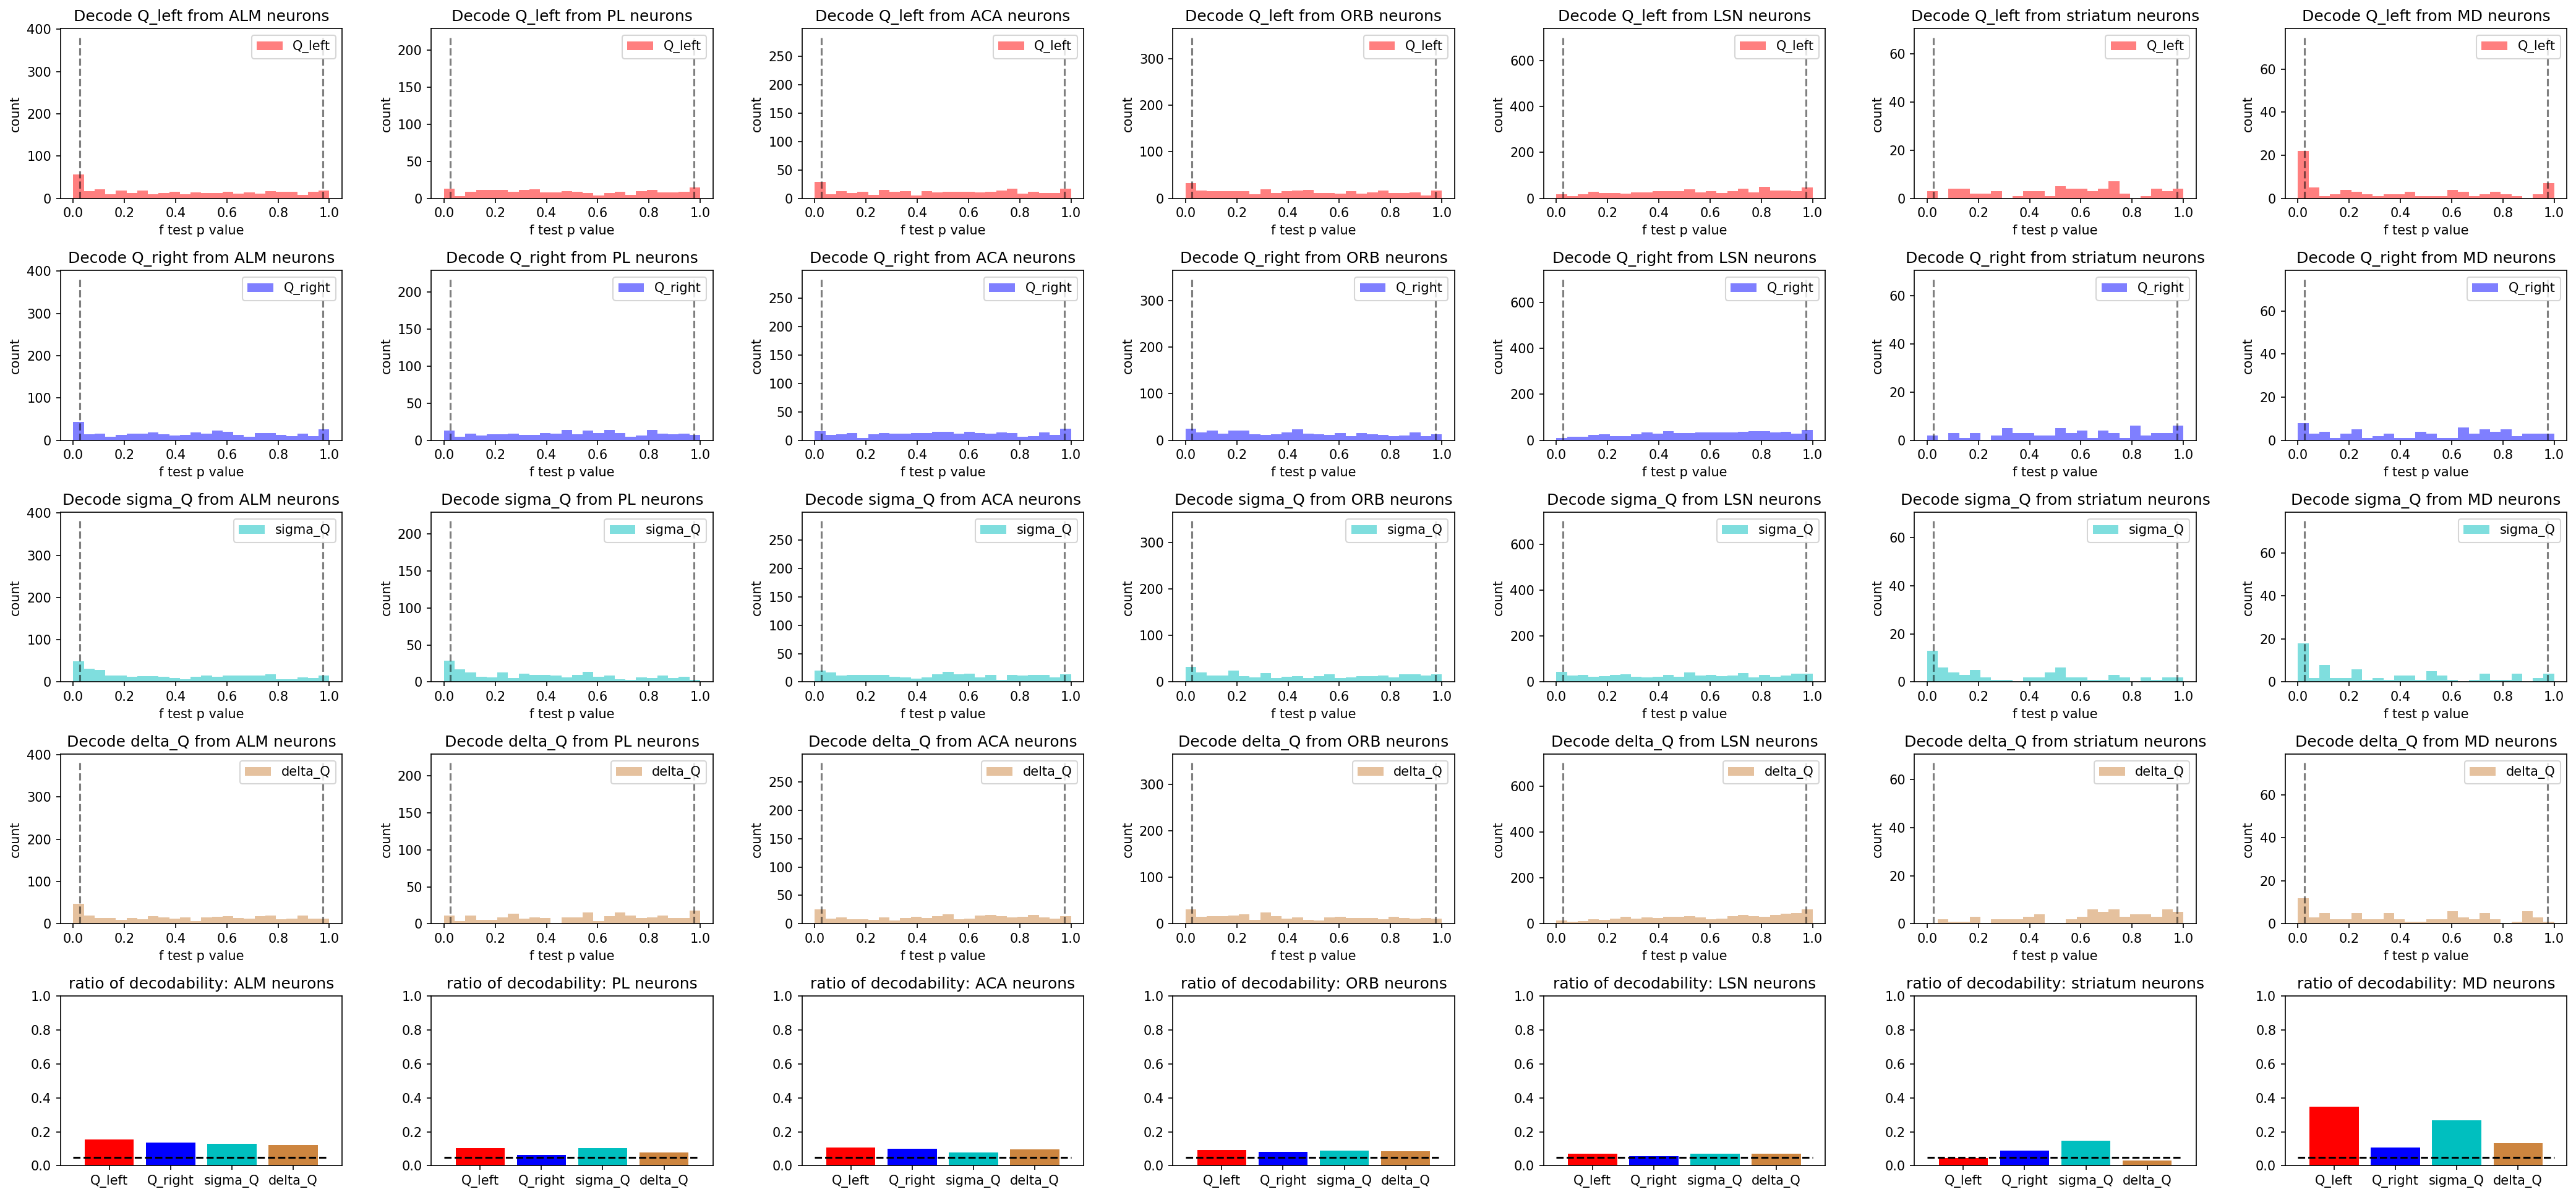

In [81]:
# plot ps fit, single neuron decoding

with open('./ephys_ps_decode.pickle', 'rb') as handle:
    df_ps_decode_dict = pickle.load(handle)

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
percentiles_2_compute = [2.5, 97.5]

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*len(target_variables)+1),
                        dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_ps_decode_dict[region]

    # calculate percentile of ftest pvalues of self-fitted sessions
    # based on the ensemble of pseudo sessions
    df_fit_ftest_pvalue_percentile_agnt_null = pd.DataFrame(columns=['session', 'unit']+target_variables)
    for session in np.unique(df_fit['src_session'].values).astype(np.int):
        df_fit_session = df_fit[df_fit['src_session']==session]
        
        for n in np.unique(df_fit_session['unit'].values).astype(np.int):
            df_fit_session_neuron = df_fit_session[df_fit_session['unit']==n]
            ftest_pvalue_percentile_agnt_null = [session, n]

            for i, target_variable in enumerate(target_variables):
                df_fit_neuron_tv = df_fit_session_neuron[df_fit_session_neuron['target_variable']==target_variable]
                # get all ftest pvalue
                ftest_pvalues = df_fit_neuron_tv['ftest_pvalue'].values
                # get self fitted ftest pvalue
                ftest_pvalue_self = df_fit_neuron_tv[df_fit_neuron_tv['src_session']==df_fit_neuron_tv['fit_session']].iloc[0]['ftest_pvalue']
                
                #ftest_pvalues_percentile = np.percentile(ftest_pvalues, percentiles_2_compute)
                ftest_pvalue_percentile_agnt_null.append(stats.percentileofscore(ftest_pvalues, ftest_pvalue_self))
            
            df_fit_ftest_pvalue_percentile_agnt_null.loc[len(df_fit_ftest_pvalue_percentile_agnt_null.index)] = ftest_pvalue_percentile_agnt_null


    n_fitted_neurons = len(df_fit_ftest_pvalue_percentile_agnt_null)
    n_sig_neurons = {target_variable: None for target_variable in target_variables}
    # histogram of regression tvalues
    for i, target_variable in enumerate(target_variables):
        row_ind = i

        ftest_pvalues_percentile_against_null_tv = df_fit_ftest_pvalue_percentile_agnt_null[target_variable].values
        ftest_pvalues_percentile_against_null_tv /= 100.0
        
        hist_tv, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues_percentile_against_null_tv, 
                                                   bins=24, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                   color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(np.array(percentiles_2_compute)/100.0, 0, n_fitted_neurons,
                                     color='k', linestyle='--', alpha=0.5)
        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {region} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_neurons[target_variable] = np.sum((ftest_pvalues_percentile_against_null_tv < 0.025) | 
                                                (ftest_pvalues_percentile_against_null_tv > 0.975))
        

    # bar plot for significant neurons
    row_ind = len(target_variables)
    
    classified_ratios = [n_sig_neurons[target_variable]/ float(n_fitted_neurons) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decodability: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1)

plt.tight_layout()

In [82]:
df_fit_ftest_pvalue_percentile_agnt_null

,session,unit,Q_left,Q_right,sigma_Q,delta_Q
0,57.0,0.0,0.016529,0.024793,0.570248,0.008264
1,57.0,3.0,0.561983,0.471074,0.090909,0.859504
2,57.0,6.0,0.297521,0.818182,0.429752,0.537190
3,57.0,8.0,0.487603,0.809917,0.247934,0.876033
4,57.0,9.0,0.024793,0.049587,0.933884,0.090909
...,...,...,...,...,...,...
70,60.0,348.0,0.041322,0.099174,0.834711,0.033058
71,60.0,349.0,1.000000,0.628099,0.528926,0.743802
72,60.0,351.0,0.983471,0.727273,0.570248,0.884298
73,60.0,352.0,0.752066,0.785124,0.975207,0.768595


In [ ]:
# ps fit, poppulation decoding
# compute the test statistic: t values of regression with q generation
# generating pseudo sessions (pseudo Qs)

n_pseudo_sessions = 120
n_pseudo_sessions_pool = 360

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']

ps_decode_pop_columns = ['src_session', 'fit_session', 'target_variable', 'ftest_pvalue']
df_ps_decode_pop_dict = {region: pd.DataFrame(columns=ps_decode_pop_columns) for region in regions_to_fit}


# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    df_pseudo_sessions = pseudo_sessions_dict[region]

    df_ps_fit = df_ps_decode_pop_dict[region]


    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]

        # get population activity
        fr = np.empty((neurons_region_session.iloc[0]['firing_rates'].shape[0], 
                       len(neurons_region_session)))
        for j in range(len(neurons_region_session)):
            fr[:, j] = neurons_region_session.iloc[j]['firing_rates']
        fr = sm.add_constant(fr)
        print(f' sess {session} fr shape {fr.shape}')

        # get Qs
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        n_trials = len(df_Qs_session)
        print(f' session {session}: {n_trials}')

        # get pseudo Qs
        df_pseudo_sessions_session = df_pseudo_sessions[df_pseudo_sessions['src_session']==session]
        df_pseudo_sessions_session_sample = df_pseudo_sessions_session.sample(n=n_pseudo_sessions)


        for target_variable in target_variables:
            # fit true session
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            # decoding models: fr --> X
            model = sm.OLS(X, fr)
            results = model.fit()
            df_ps_fit.loc[len(df_ps_fit.index)] = [session, session, 
                                                   target_variable, 
                                                   results.f_pvalue]

            # fit pseudo sessions
            for _, row in df_pseudo_sessions_session_sample.iterrows():
                X_pseudo = row['q_pseudo']
                if target_variable == 'Q_left':
                    X_pseudo = X_pseudo[:, 0]
                elif target_variable == 'Q_right':
                    X_pseudo = X_pseudo[:, 1]
                elif target_variable == 'sigma_Q':
                    X_pseudo = X_pseudo[:, 0] + X_pseudo[:, 1]
                elif target_variable == 'delta_Q':
                    X_pseudo = X_pseudo[:, 0] - X_pseudo[:, 1]
                else:
                    raise ValueError('incorrect target variable type!')

                # decoding models: fr --> X
                model = sm.OLS(X_pseudo, fr)
                results = model.fit()
                df_ps_fit.loc[len(df_ps_fit.index)] = [session, -1*(row['gen_id']),
                                                       target_variable, 
                                                       results.f_pvalue]

In [ ]:
# save the ps population decoding df if not existed
#with open('./ephys_ps_decode_pop.pickle', 'wb') as handle:
#    pickle.dump(df_ps_decode_pop_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

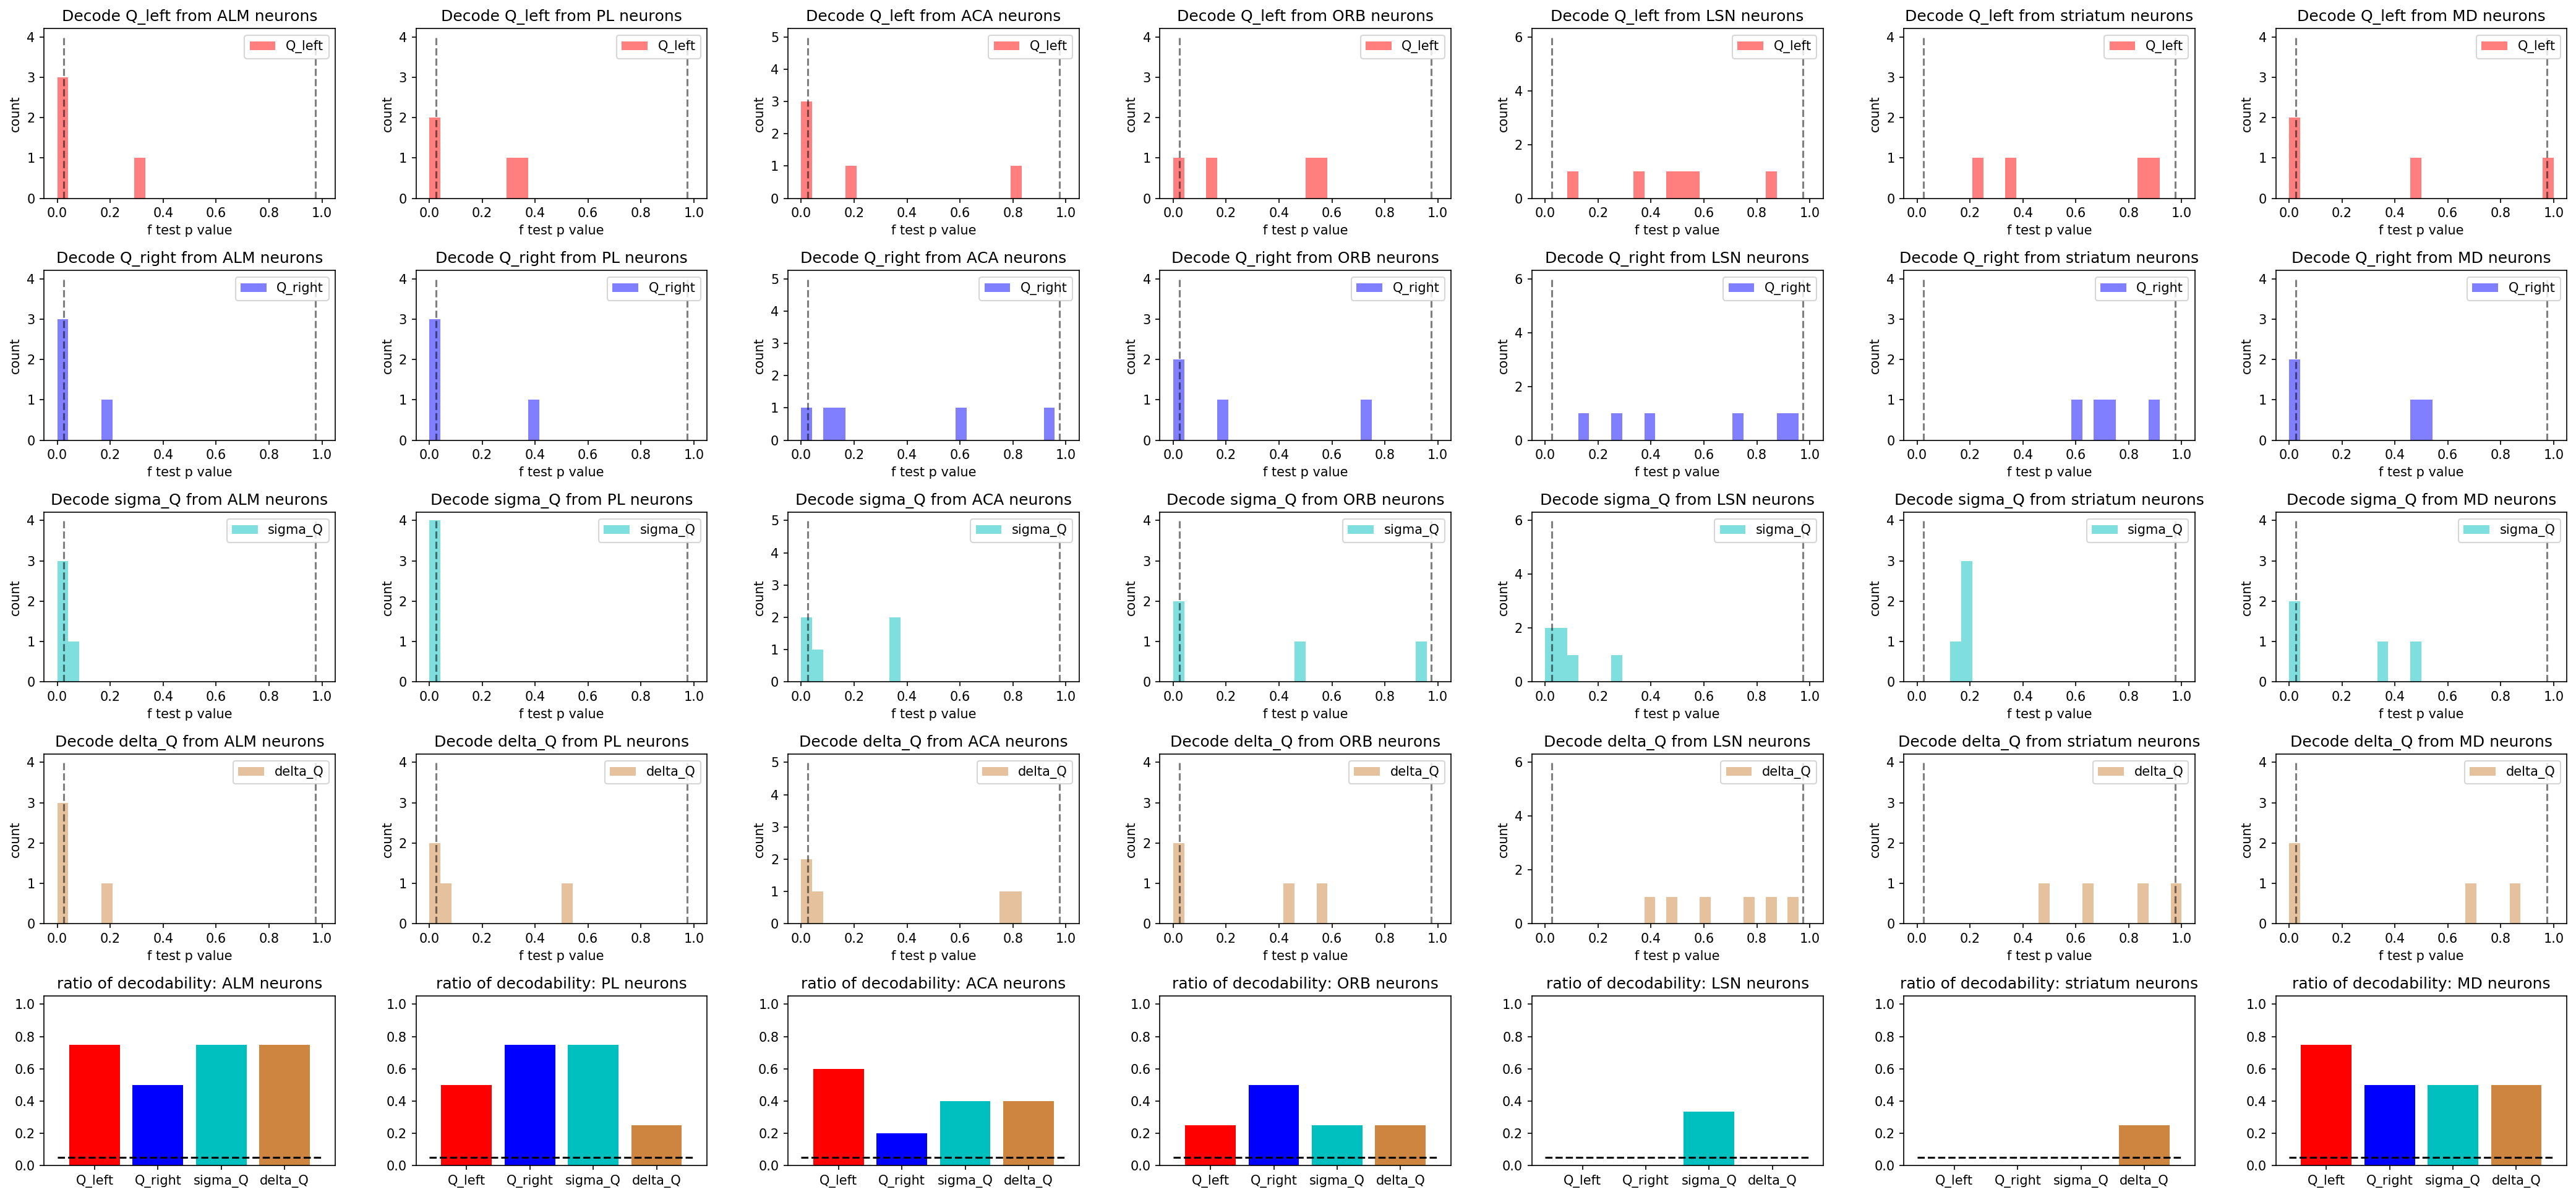

In [79]:
# plot ps fit, poppulation decoding

with open('./ephys_ps_decode_pop.pickle', 'rb') as handle:
    df_ps_decode_pop_dict = pickle.load(handle)

regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
percentiles_2_compute = [2.5, 97.5]

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*len(target_variables)+1),
                        dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_ps_decode_pop_dict[region]

    # calculate percentile of ftest pvalues of self-fitted sessions
    # based on the ensemble of pseudo sessions
    df_fit_ftest_pvalue_percentile_agnt_null = pd.DataFrame(columns=['session']+target_variables)
    for session in np.unique(df_fit['src_session'].values).astype(np.int):
        df_fit_session = df_fit[df_fit['src_session']==session]
    
        ftest_pvalue_percentile_agnt_null = [session]

        for i, target_variable in enumerate(target_variables):
            df_fit_session_tv = df_fit_session[df_fit_session['target_variable']==target_variable]
            # get all ftest pvalue
            ftest_pvalues = df_fit_session_tv['ftest_pvalue'].values
            # get self fitted ftest pvalue
            ftest_pvalue_self = df_fit_session_tv[df_fit_session_tv['src_session']==df_fit_session_tv['fit_session']].iloc[0]['ftest_pvalue']
            
            #ftest_pvalues_percentile = np.percentile(ftest_pvalues, percentiles_2_compute)
            ftest_pvalue_percentile_agnt_null.append(stats.percentileofscore(ftest_pvalues, ftest_pvalue_self))
        
        df_fit_ftest_pvalue_percentile_agnt_null.loc[len(df_fit_ftest_pvalue_percentile_agnt_null.index)] = ftest_pvalue_percentile_agnt_null


    n_fitted_sessions = len(df_fit_ftest_pvalue_percentile_agnt_null)
    n_sig_sessions = {target_variable: None for target_variable in target_variables}
    # histogram of regression tvalues
    for i, target_variable in enumerate(target_variables):
        row_ind = i

        ftest_pvalues_percentile_against_null_tv = df_fit_ftest_pvalue_percentile_agnt_null[target_variable].values
        ftest_pvalues_percentile_against_null_tv /= 100

        hist_tv, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues_percentile_against_null_tv, 
                                                   bins=24, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                   color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(np.array(percentiles_2_compute)/100.0, 0, n_fitted_sessions,
                                     color='k', linestyle='--', alpha=0.5)
        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {region} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_sessions[target_variable] = np.sum((ftest_pvalues_percentile_against_null_tv < 0.025) | 
                                                 (ftest_pvalues_percentile_against_null_tv > 0.975))
        

    # bar plot for significant neurons
    row_ind = len(target_variables)

    classified_ratios = [n_sig_sessions[target_variable]/ float(n_fitted_sessions) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decodability: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1.05)

plt.tight_layout()